In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
import seaborn as sns
import scipy
import dask
import h5py
from xgcm import Grid
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from cycler import cycler
import cmocean
from matplotlib.colors import TwoSlopeNorm
np.random.seed(4321)
plt.rcParams.update({'font.size': 10})
# mpl.rcParams['animation.embed_limit'] = 2**128
print('all done')
%matplotlib inline
nanmasked = plt.get_cmap('turbo_r').copy()
nanmasked.set_bad('black')
nanmasked2 = plt.get_cmap('cmo.balance_r').copy()
nanmasked2.set_bad('black')
from dask.diagnostics import ProgressBar

all done


### Loading z* coordinate data + static grid data

In [13]:
# # open the 5 year dataset
# ds = xr.open_mfdataset('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/control/**/*budgets*.nc',chunks='auto',engine='h5netcdf',combine='nested',concat_dim='time',decode_timedelta='CFTimedeltaCoder')
ds = xr.open_mfdataset('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/budgets/box6.nc',chunks='auto',engine='h5netcdf',combine='nested',concat_dim='time',decode_timedelta='CFTimedeltaCoder')

# # ## full static on the native full grid cropped to region
data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/OUTPUT/control/1997/19970101.ocean_static.nc'
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/budgets/box1.nc'
static = xr.open_dataset(data_path,chunks='auto')
static = static.isel(xh=slice(0,601),yh=slice(0,343),xq=slice(0,601),yq=slice(0,343))
print('data loaded!')

data loaded!


Here we define the xgcm grid to use for averaging and summing operations. We must be careful because the averaging and summing operations by default do not account for the partially-filled cells due to land, so we must use the grid to make sure that the average is weighted by the actual area or volume that the cell contains. Note that this applies to horizontal or 3d integrated values, but not to z values alone because, by construction, the z layers are completely filled or not filled at all. 

In [5]:
### defining xgcm grid for best practices 

ds['dxt'] = static['dxt'].fillna(0.)
ds['dyt'] = static['dyt'].fillna(0.)
ds['areacello'] = static['areacello'].fillna(0.)
ds['depth_ocean'] = static['depth_ocean']#.fillna(0.)
ds['wet'] = static['wet']

metrics = {
    ('X',): ['dxt'], # X distances
    ('Y',): ['dyt'], # Y distances
    ('X', 'Y'): ['areacello'] # Areas
}

coords={'X': {'center': 'xh', 'right': 'xq'},
        'Y': {'center': 'yh', 'right': 'yq'},
       'time': {'center':'time'}}

# ds = xr.merge([ds,static]) # we have to merge so that the time dimension will be processed correctly
ds = ds.unify_chunks()

grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

# ### defining xgcm grid for best practices 

# static['dxt'] = static['dxt'].fillna(0.)
# static['dyt'] = static['dyt'].fillna(0.)
# static['areacello'] = static['areacello'].fillna(0.)

# metrics = {
#     ('X',): ['dxt'], # X distances
#     ('Y',): ['dyt'], # Y distances
#     ('X', 'Y'): ['areacello'] # Areas
# }

# coords={'X': {'center': 'xh', 'right': 'xq'},
#         'Y': {'center': 'yh', 'right': 'yq'}}

# grid = Grid(static, coords=coords, metrics=metrics, periodic=[])#not periodic because it's a regional model, periodic=['X'])

# ### create mask for topography if in native z coordinates

# mask = np.tile(ds.zl,[601,343,1]) # zgrid tiled for each grid point
# mask = mask.T 

# mask2 = np.tile(static.depth_ocean,[75,1,1]) # seafloor depth tiled for each z level

# mask3 = mask<=mask2

# # land=0, ocean=1
# static['wet_depth'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zl': ds['zl'],'yh': ds['yh'],'xh': ds['xh']},
#                          dims=('zl','yh','xh'))

# static['wet_depth_xq'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zl': ds['zl'],'yh': ds['yh'],'xq': ds['xq']},
#                          dims=('zl','yh','xq'))

# static['wet_depth_yq'] = xr.DataArray(data=mask3.astype('int'),
#                          coords={'zl': ds['zl'],'yq': ds['yq'],'xh': ds['xh']},
#                          dims=('zl','yq','xh'))

# del mask3, mask2, mask

## Heat budget closure on the native grid

### Cell-by-cell closure
Keep in mind that for some reason, the budget does not close for time=0, so we start from time=1 and so on.

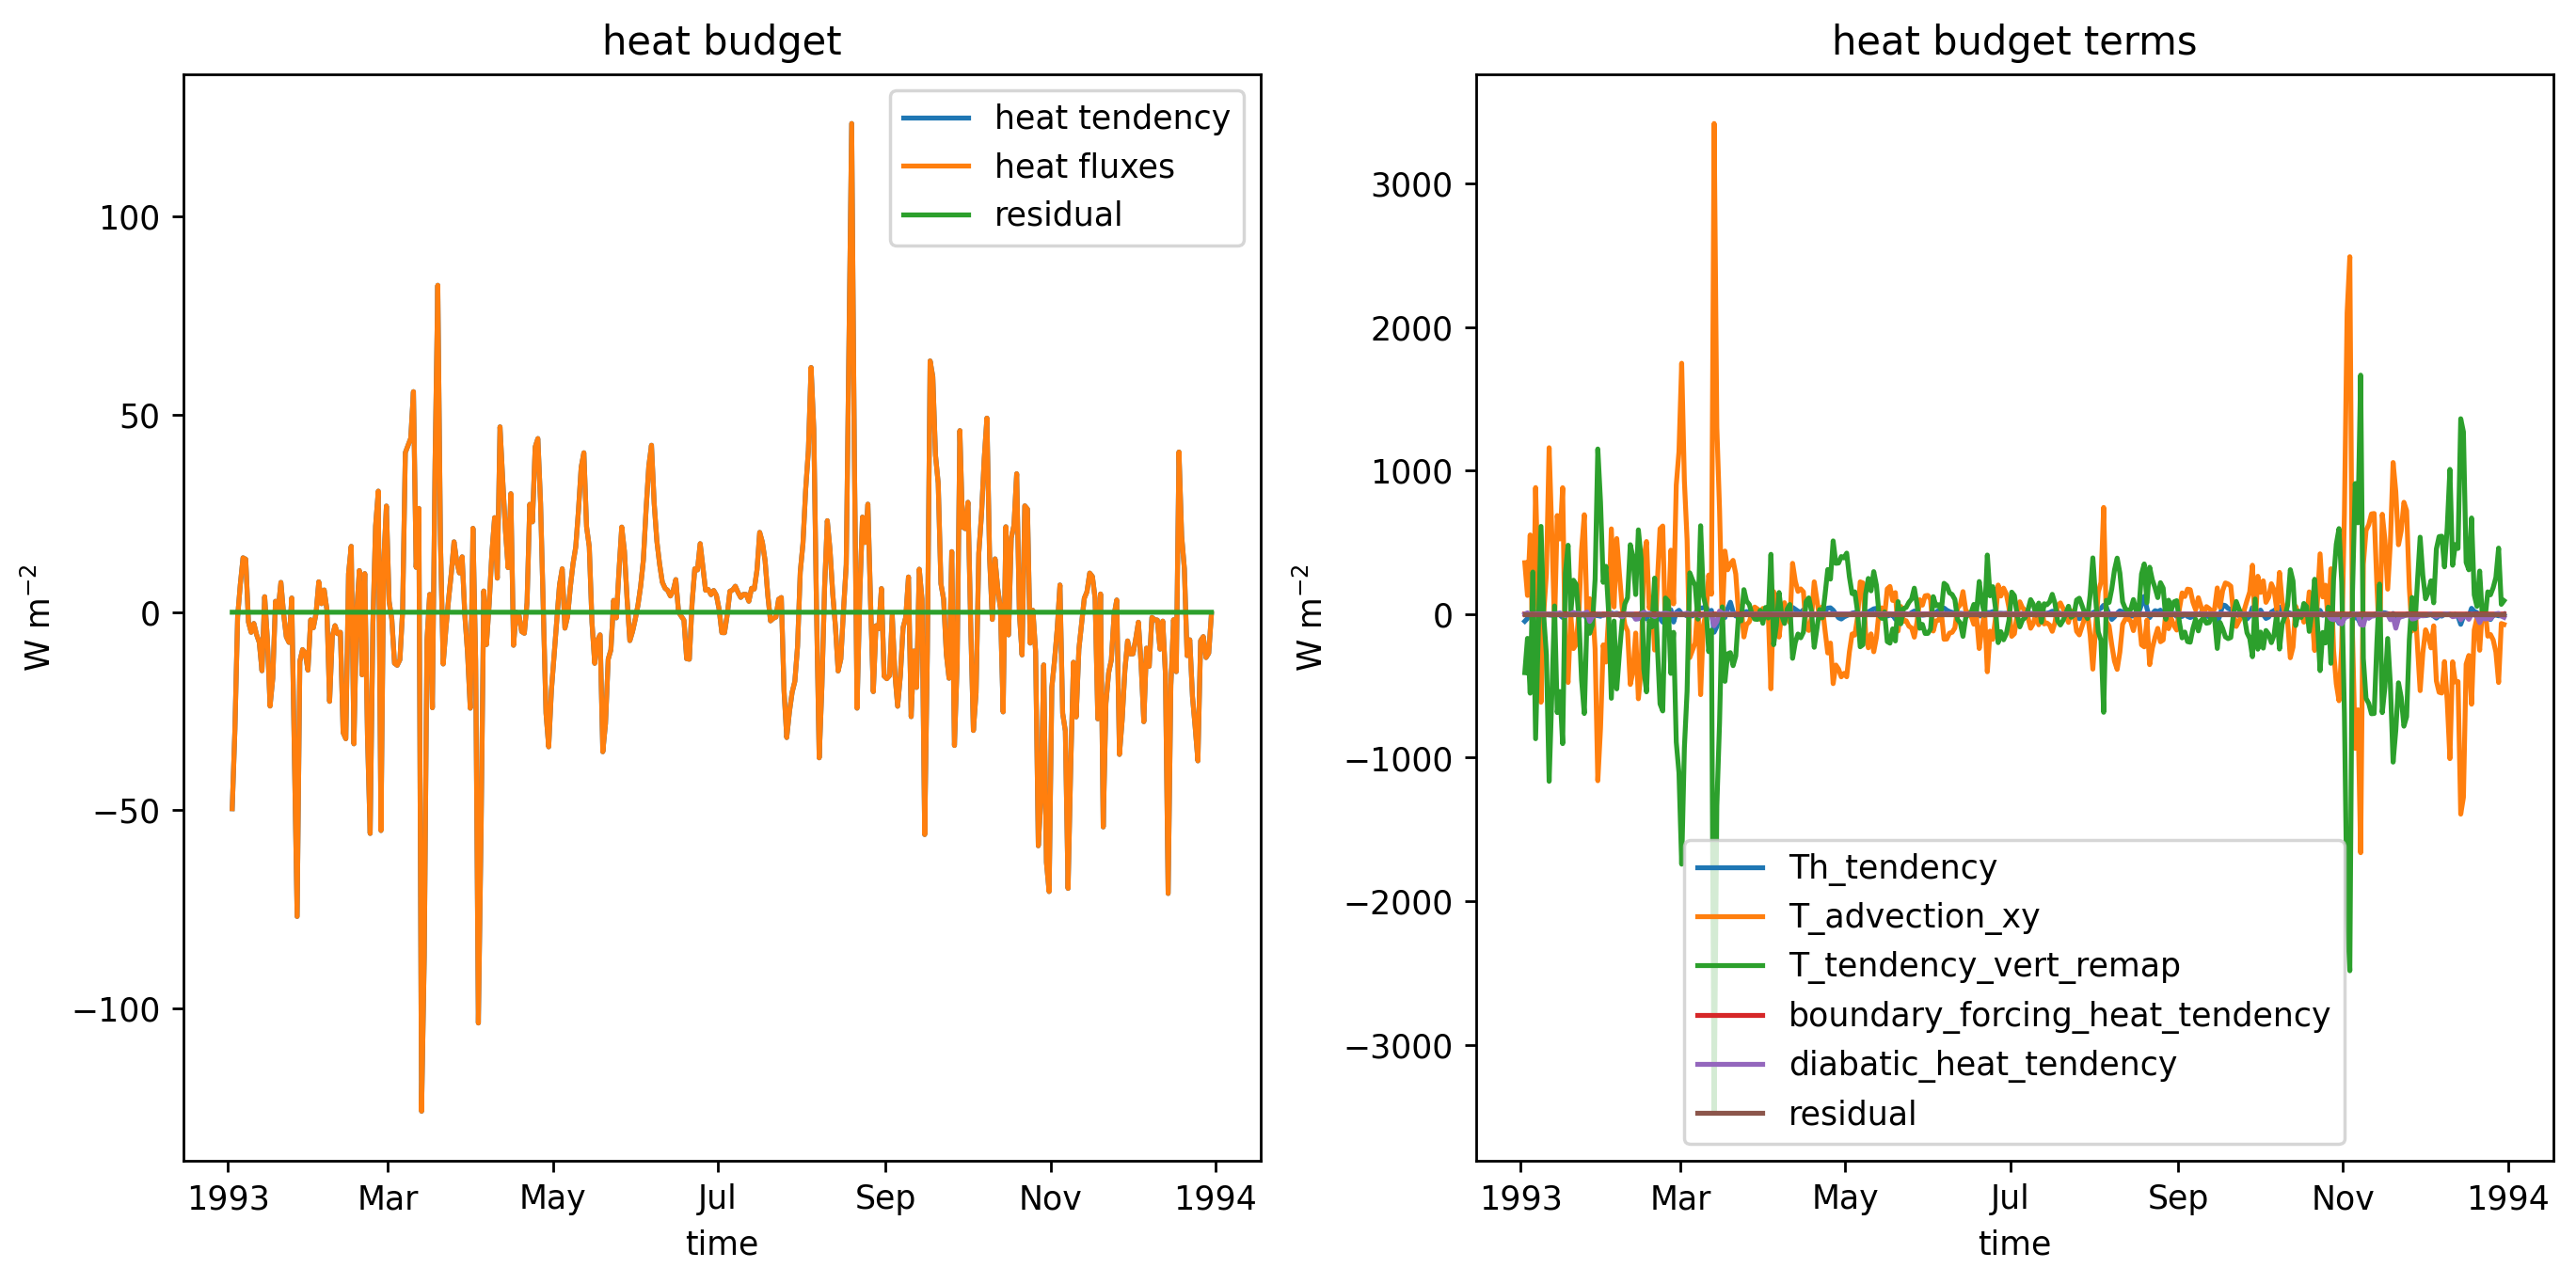

In [10]:
terms = {}
terms['heat'] = ['Th_tendency','T_advection_xy','T_tendency_vert_remap','boundary_forcing_heat_tendency','diabatic_heat_tendency']

# # cell-by-cell budget xh=50,yh=300,zl=20
x = 50 # longitude index
y = 300 # latitude index
z = 20 # depth index
fluxes = ds.T_advection_xy.isel(xh=x,yh=y,zl=z).squeeze() + ds.T_tendency_vert_remap.isel(xh=x,yh=y,zl=z).squeeze() + ds.boundary_forcing_heat_tendency.isel(xh=x,yh=y,zl=z).squeeze() + ds.diabatic_heat_tendency.isel(xh=x,yh=y,zl=z).squeeze() 

fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=250)
fluxes.isel(time=slice(1,-1)).plot(x='time',ax=ax[0])
ds.Th_tendency.isel(xh=x,yh=y,zl=z,time=slice(1,-1)).plot(x='time',ax=ax[0])
diff = ds.Th_tendency.isel(xh=x,yh=y,zl=z,time=slice(1,-1)) - fluxes.isel(time=slice(1,-1))
diff.plot(x='time',ax=ax[0])
ax[0].set_ylabel('W m$^{-2}$')
ax[0].set_title('heat budget')
ax[0].legend(['heat tendency','heat fluxes', 'residual'])

# fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=250)
for term in terms['heat']:
        ds[term].isel(xh=x,yh=y,zl=z,time=slice(1,-1)).plot(x='time',ax=ax[1])
diff.plot(x='time',ax=ax[1])
ax[1].set_ylabel('W m$^{-2}$')
ax[1].set_title('heat budget terms')
ax[1].legend(terms['heat']+['residual'],fontsize=10)
plt.show()

### Vertically-integrated closure

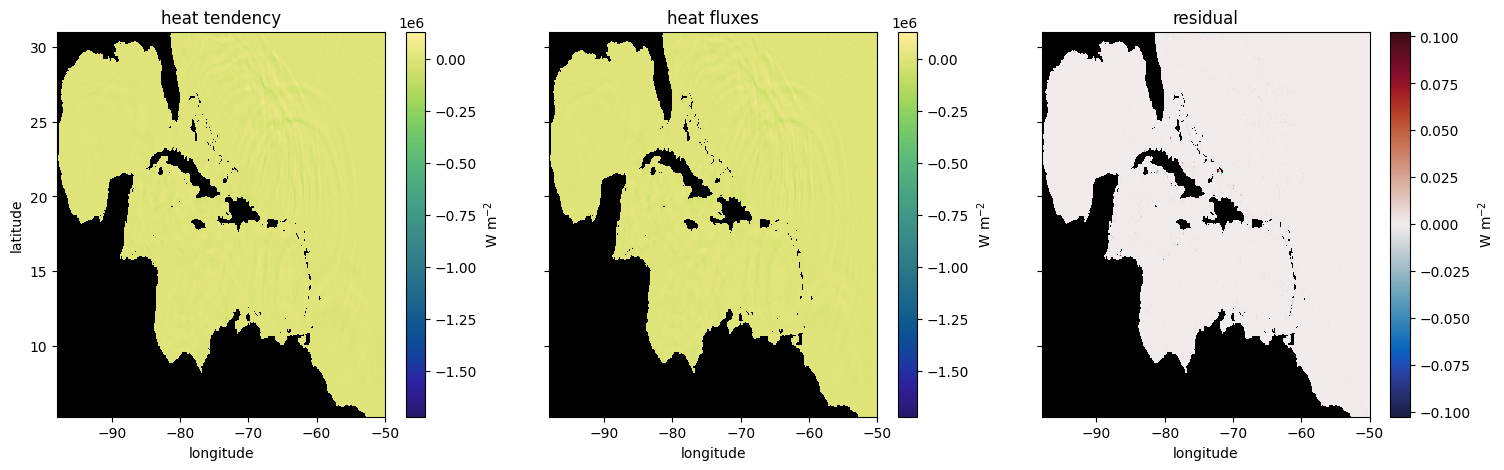

In [7]:
fluxes = ds.T_advection_xy + ds.T_tendency_vert_remap + ds.boundary_forcing_heat_tendency + ds.diabatic_heat_tendency
diff = ds.Th_tendency.sum('zl').squeeze() - fluxes.sum('zl').squeeze()
heatmin = ds.Th_tendency.sum('zl').min().values
heatmax = ds.Th_tendency.sum('zl').max().values

set_time = 3
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ds.Th_tendency.sum('zl').where(np.isnan(ds.Th_tendency.isel(zl=0))==0).isel(time=set_time).plot(x='xh',y='yh',ax=ax[0],cmap=nanmasked,vmin=heatmin,vmax=heatmax,cbar_kwargs={'label':'W m$^{-2}$'})
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[0].set_title('heat tendency')
fluxes.sum('zl').where(np.isnan(ds.Th_tendency.isel(zl=0))==0).isel(time=set_time).plot(x='xh',y='yh',ax=ax[1],cmap=nanmasked,vmin=heatmin,vmax=heatmax,cbar_kwargs={'label':'W m$^{-2}$'})
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[1].set_xlabel('longitude')
ax[1].set_title('heat fluxes')
diff.where(np.isnan(ds.Th_tendency.isel(zl=0))==0).isel(time=set_time).plot(x='xh',y='yh',ax=ax[2],cmap=nanmasked2,cbar_kwargs={'label':'W m$^{-2}$'})
ax[2].set_ylabel('')
ax[2].set_yticklabels('')
ax[2].set_xlabel('longitude')
ax[2].set_title('residual')
plt.show()

## Oxygen content budget closure on the native grid

### Cell-by-cell closure
Again, keep in mind that the budget does not close at time=0. 

In [6]:
## cell-by-cell budget xh=50,yh=300,zl=0
x = 540 # longitude index
y = 300 # latitude index
z = 10 # depth index
dstest = ds.isel(xh=x,yh=y,zl=z).compute()

In [8]:
terms = {}
terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

## cell-by-cell budget xh=50,yh=300,zl=0
x = 540 # longitude index
y = 300 # latitude index
z = 10 # depth index

fluxes = ds.o2_advection_xy.isel(xh=x,yh=y,zl=z).squeeze().compute() + ds.o2h_tendency_vert_remap.isel(xh=x,yh=y,zl=z).squeeze().compute()  + ds.o2_diffusion_xy.isel(xh=x,yh=y,zl=z).squeeze().compute() + ds.o2_vdiffuse_impl.isel(xh=x,yh=y,zl=z).squeeze().compute() + ds.jo2.isel(xh=x,yh=y,zl=z).squeeze().compute()/1035 

fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=250)
fluxes.isel(time=slice(1,None)).plot(x='time',ax=ax[0])
ds.o2h_tendency.isel(xh=x,yh=y,zl=z,time=slice(1,None)).plot(x='time',ax=ax[0])
diff = ds.o2h_tendency.isel(xh=x,yh=y,zl=z,time=slice(1,None)) - fluxes.isel(time=slice(1,None))
diff.plot(x='time',ax=ax[0])
ax[0].set_ylabel('mol kg$^{-1}$ m s$^{-1}$')
ax[0].set_title('O$_2$ content budget')
ax[0].legend(['O$_2$ fluxes','O$_2$ tendency', 'residual'])

# # fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=250)
# for term in terms['o2cont']:
#     if term=='jo2':
#         throwaway = ds[term].isel(xh=x,yh=y,zl=z,time=slice(1,None))/1035
#         throwaway.plot(x='time',ax=ax[1])
#     else:
#         throwaway = ds[term].isel(xh=x,yh=y,zl=z,time=slice(1,None))
#         throwaway.plot(x='time',ax=ax[1])
# diff.plot(x='time',ax=ax[1])
# ax[1].set_ylabel('mol kg$^{-1}$ m s$^{-1}$')
# ax[1].set_title('O$_2$ content terms')
# ax[1].legend(terms['o2cont']+['residual'],fontsize=10)

### Vertically-integrated closure

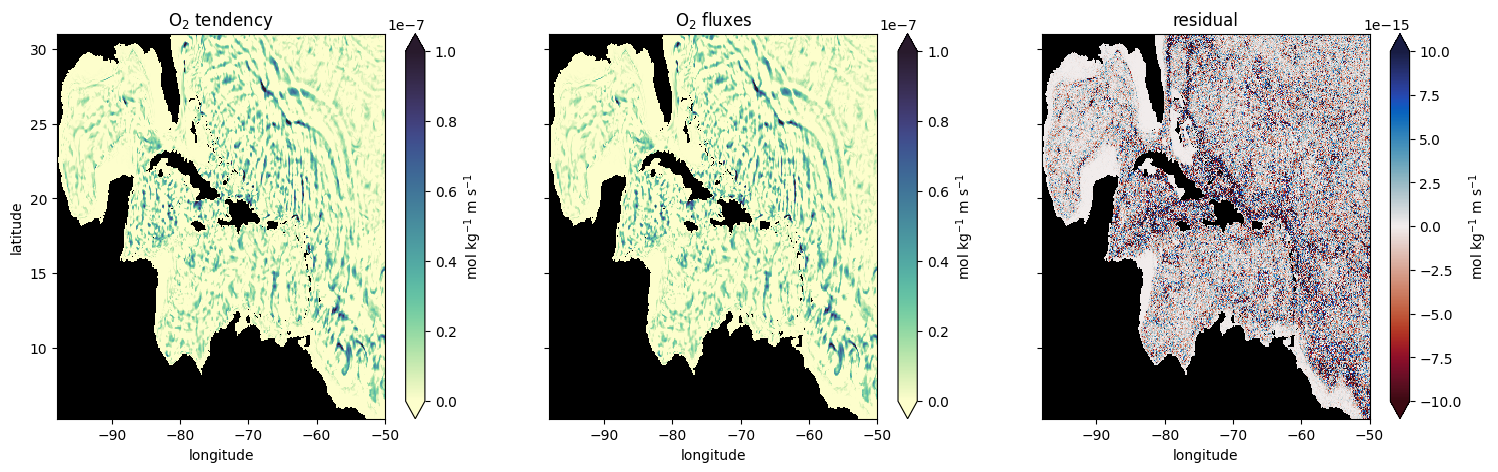

In [6]:
# fluxes = ds.o2_advection_xy + ds.o2h_tendency_vert_remap + ds.o2_diffusion_xy + ds.o2_vdiffuse_impl + ds.jo2/1035 
diff = ds.o2h_tendency.sum('zl').squeeze() - fluxes.sum('zl').squeeze()
## o2min = ds.o2h_tendency.sum('zl').min().values
## o2max = ds.o2h_tendency.sum('zl').max().values

set_time = 3
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ds.o2h_tendency.sum('zl').where(static.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[0],cmap=nanmasked,vmin=0,vmax=1e-7,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[0].set_title('O$_2$ tendency')
fluxes.sum('zl').where(static.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[1],cmap=nanmasked,vmin=0,vmax=1e-7,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[1].set_xlabel('longitude')
ax[1].set_title('O$_2$ fluxes')
diff.where(static.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[2],cmap=nanmasked2,vmin=-1e-14,vmax=1e-14,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[2].set_ylabel('')
ax[2].set_yticklabels('')
ax[2].set_xlabel('longitude')
ax[2].set_title('residual')
plt.show()

## Box budget closure on native grid

Let's consider a box between -92 to -89.5 degrees longitude, 21 to 24 degrees latitude from surface to seafloor. We should first verify that all the fluxes summed over each of the spatial dimensions should be equal to the summed tendency of the box. 
### Heat budget closure

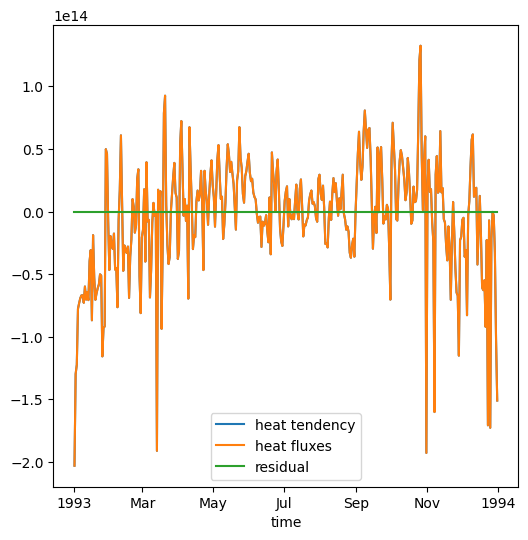

In [10]:
box = ds.sel(**{'xh': slice(-92, -89.5),'yh': slice(21, 24)}) #.isel(zl=slice(0,40))
terms = {}
terms['heat'] = ['Th_tendency','T_advection_xy','T_tendency_vert_remap','boundary_forcing_heat_tendency','diabatic_heat_tendency']
terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

fluxes = box.T_advection_xy + box.T_tendency_vert_remap + box.boundary_forcing_heat_tendency + box.diabatic_heat_tendency
diff = grid.integrate(box.Th_tendency,['X','Y']).sum(['zl']).squeeze() - grid.integrate(box.Th_tendency,['X','Y']).sum(['zl']).squeeze()

fig, ax = plt.subplots(1, 1, figsize=(6,6))
grid.integrate(box.Th_tendency,['X','Y']).sum(['zl']).plot(x='time')
grid.integrate(fluxes,['X','Y']).sum(['zl']).plot(x='time')
diff.plot(x='time')
ax.legend(['heat tendency','heat fluxes', 'residual'],fontsize=10)

### Oxygen budget closure

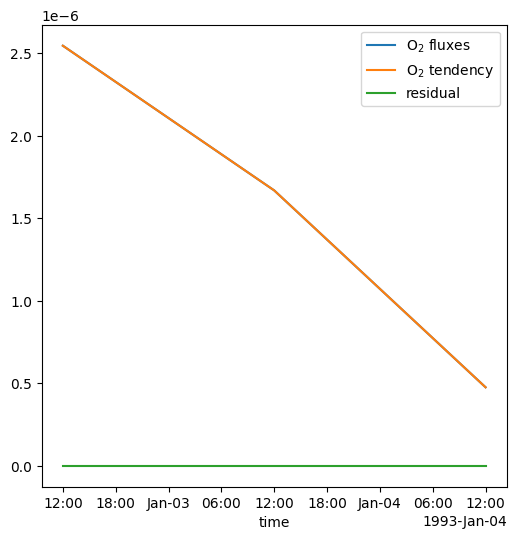

In [14]:
fluxes = box.o2_advection_xy + box.o2h_tendency_vert_remap + box.o2_diffusion_xy + box.o2_vdiffuse_impl + box.jo2/1035
diff = box.o2h_tendency.sum(['xh','yh','zl']).squeeze() - fluxes.sum(['xh','yh','zl']).squeeze()

fig, ax = plt.subplots(1, 1, figsize=(6,6))
box.o2h_tendency.sum(['xh','yh','zl']).isel(time=slice(2,-1)).plot(x='time')
fluxes.sum(['xh','yh','zl']).isel(time=slice(2,-1)).plot(x='time')
diff.isel(time=slice(2,-1)).plot(x='time')
ax.legend(['O$_2$ fluxes','O$_2$ tendency', 'residual'],fontsize=10)

### Recreating oxygen time series via fluxes and tendency
We can check whether the o2h tendency time series matches the o2 model output. Below is an example for one point:

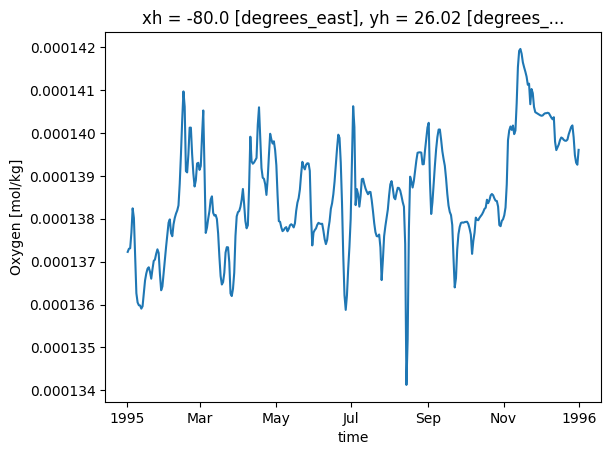

In [30]:
# lon = np.abs(ds.xh- -80).argmin()
lat = np.abs(ds.yh- 26).argmin()
depth = np.abs(ds.zl- 200).argmin()
ds.o2.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth).plot()

In [31]:
o2_int = ds.o2.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth).values
adv = (ds.o2_advection_xy.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth) + ds.o2h_tendency_vert_remap.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth)).values
diff = (ds.o2_vdiffuse_impl.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth) + ds.o2_diffusion_xy.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth)).values
bio = (ds.jo2.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth)/1035).values
thk = ds.h.where(static.wet_depth).isel(xh=lon,yh=lat,zl=depth).values
nodiff = (diff/thk)*60*60*24
noadv = (adv/thk)*60*60*24
nobio = (bio/thk)*60*60*24
fluxes =  ((adv + diff + bio)/thk)*60*60*24

o2_nodiff = 0*o2_int
o2_nodiff[0] = o2_int[0]
o2_noadv = 0*o2_int
o2_noadv[0] = o2_int[0]
o2_nobio = 0*o2_int
o2_nobio[0] = o2_int[0]
o2_fluxes = 0*o2_int
o2_fluxes[0] = o2_int[0]

for i in range(1,365):
    o2_fluxes[i] = o2_fluxes[i-1] + fluxes[i-1]
    o2_nodiff[i] = o2_nodiff[i-1]+nodiff[i-1] # o2 no diffusion 
    o2_noadv[i] = o2_noadv[i-1]+noadv[i-1] # o2 no diffusion 
    o2_nobio[i] = o2_nobio[i-1]+nobio[i-1] # o2 no diffusion 

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2444227/538533139.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('o2 [$\mu$mol/kg]')
/tmp/ipykernel_2444227/538533139.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.title('({:0.2f}'.format(ds.xh[lon].values) + '$^{\circ}$E, ' + '{:0.2f}'.format(ds.yh[lat].values)+ '$^{\circ}$N)' + ' at depth {:0.2f}'.format(ds.zl[depth].values)+ ' m')
/tmp/ipykernel_2444227/538533139.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.title('({:0.2f}'.format(ds.xh[lon].values) + '$^{\circ}$E, ' + '{:0.2f}'.format(ds.yh[lat].values)+ '$^{\circ}$N)' + ' at depth {:0.2f}'.format(ds.zl[depth].values)+ ' m')


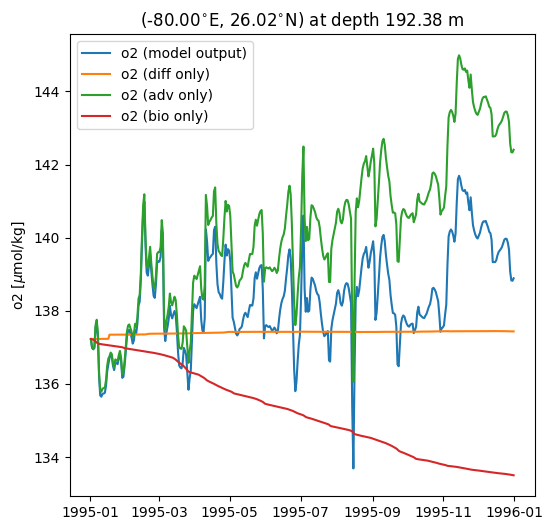

In [33]:
## plotting the time series

fig, ax = plt.subplots(1, 1, figsize=(6,6))
plt.plot(ds.time, 1e6*o2_fluxes)
plt.plot(ds.time, 1e6*o2_nodiff)
plt.plot(ds.time, 1e6*o2_noadv)
plt.plot(ds.time, 1e6*o2_nobio)
plt.ylabel('o2 [$\mu$mol/kg]')
plt.title('({:0.2f}'.format(ds.xh[lon].values) + '$^{\circ}$E, ' + '{:0.2f}'.format(ds.yh[lat].values)+ '$^{\circ}$N)' + ' at depth {:0.2f}'.format(ds.zl[depth].values)+ ' m')
plt.legend(['o2 (model output)', 'o2 (diff only)','o2 (adv only)','o2 (bio only)'])

In [46]:
# adding to the time series

## longitude -85 xh=162, latitude: 17 yh=150, depth: 679 zl=46

lon = np.abs(ds.xh- -80).argmin()
lat = np.abs(ds.yh- 15).argmin()
depth = np.abs(ds.zl- 700).argmin()

o2_int = ds.o2.where(static.wet_depth).isel(xh=lon,yh=lat).values
adv = (ds.o2_advection_xy.where(static.wet_depth).isel(xh=lon,yh=lat) + ds.o2h_tendency_vert_remap.where(static.wet_depth).isel(xh=lon,yh=lat)).values
diff = (ds.o2_vdiffuse_impl.where(static.wet_depth).isel(xh=lon,yh=lat) + ds.o2_diffusion_xy.where(static.wet_depth).isel(xh=lon,yh=lat)).values
bio = (ds.jo2.where(static.wet_depth).isel(xh=lon,yh=lat)/1035).values
thk = ds.h.where(static.wet_depth).isel(xh=lon,yh=lat).values
nodiff = ((diff)/thk)*60*60*24
noadv = ((adv)/thk)*60*60*24
nobio = ((bio)/thk)*60*60*24
fluxes =  ((adv + diff + bio)/thk)*60*60*24

o2_nodiff = 0*o2_int
o2_nodiff[0,:] = o2_int[0,:]
o2_noadv = 0*o2_int
o2_noadv[0,:] = o2_int[0,:]
o2_nobio = 0*o2_int
o2_nobio[0,:] = o2_int[0,:]
o2_fluxes = 0*o2_int
o2_fluxes[0,:] = o2_int[0,:]

for i in range(1,365):
    o2_fluxes[i,:] = o2_fluxes[i-1,:] + fluxes[i-1,:]
    o2_nodiff[i,:] = o2_nodiff[i-1,:]+nodiff[i-1,:] # o2 no diffusion 
    o2_noadv[i,:] = o2_noadv[i-1,:]+noadv[i-1,:] # o2 no diffusion 
    o2_nobio[i,:] = o2_nobio[i-1,:]+nobio[i-1,:] # o2 no diffusion 

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1443003/3205302497.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(fluxes,label='o2 [$\mu$mol/kg]')
/tmp/ipykernel_1443003/3205302497.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.title('diffusion only\n ({:0.2f}'.format(ds.xh[lon].values)+ '$^{\circ}$E, ' +'{:0.2f}'.format(ds.yh[lat].values) + '$^{\circ}$N)') #{:0.2f}'.format(ds.xh[lon].values) + '$^{\circ}$E, '+ ' at depth {:0.2f}'.format(ds.zl[depth].values)+ ' m') +
/tmp/ipykernel_1443003/3205302497.py:9: SyntaxWarning: invalid escape sequence '\c'
  plt.title('diffusion only\n ({:0.2f}'.format(ds.xh[lon].values)+ '$^{\circ}$E, ' +'{:0.2f}'.format(ds.yh[lat].values) + '$^{\circ}$N)') #{:0.2f}'.fo

Text(0.5, 1.0, 'diffusion only\n (-80.00$^{\\circ}$E, 15.02$^{\\circ}$N)')

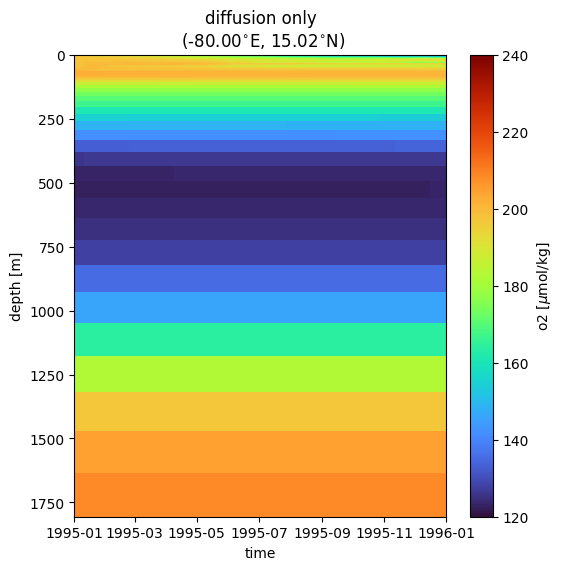

In [58]:
### hovmollers
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fluxes = plt.pcolormesh(ds.time,ds.zl[0:55],np.transpose(np.ma.masked_where(np.tile(static.wet_depth[0:55,lat,lon],(365,1))==0, 1e6*o2_nobio[:,0:55])),cmap='turbo',vmin=120,vmax=240) # mask if land (value of 0)
# plt.ylabel('[mol/kg]')
plt.gca().invert_yaxis()
plt.colorbar(fluxes,label='o2 [$\mu$mol/kg]')
plt.xlabel('time')
plt.ylabel('depth [m]')
plt.title('biology only\n ({:0.2f}'.format(ds.xh[lon].values)+ '$^{\circ}$E, ' +'{:0.2f}'.format(ds.yh[lat].values) + '$^{\circ}$N)') #{:0.2f}'.format(ds.xh[lon].values) + '$^{\circ}$E, '+ ' at depth {:0.2f}'.format(ds.zl[depth].values)+ ' m') + 

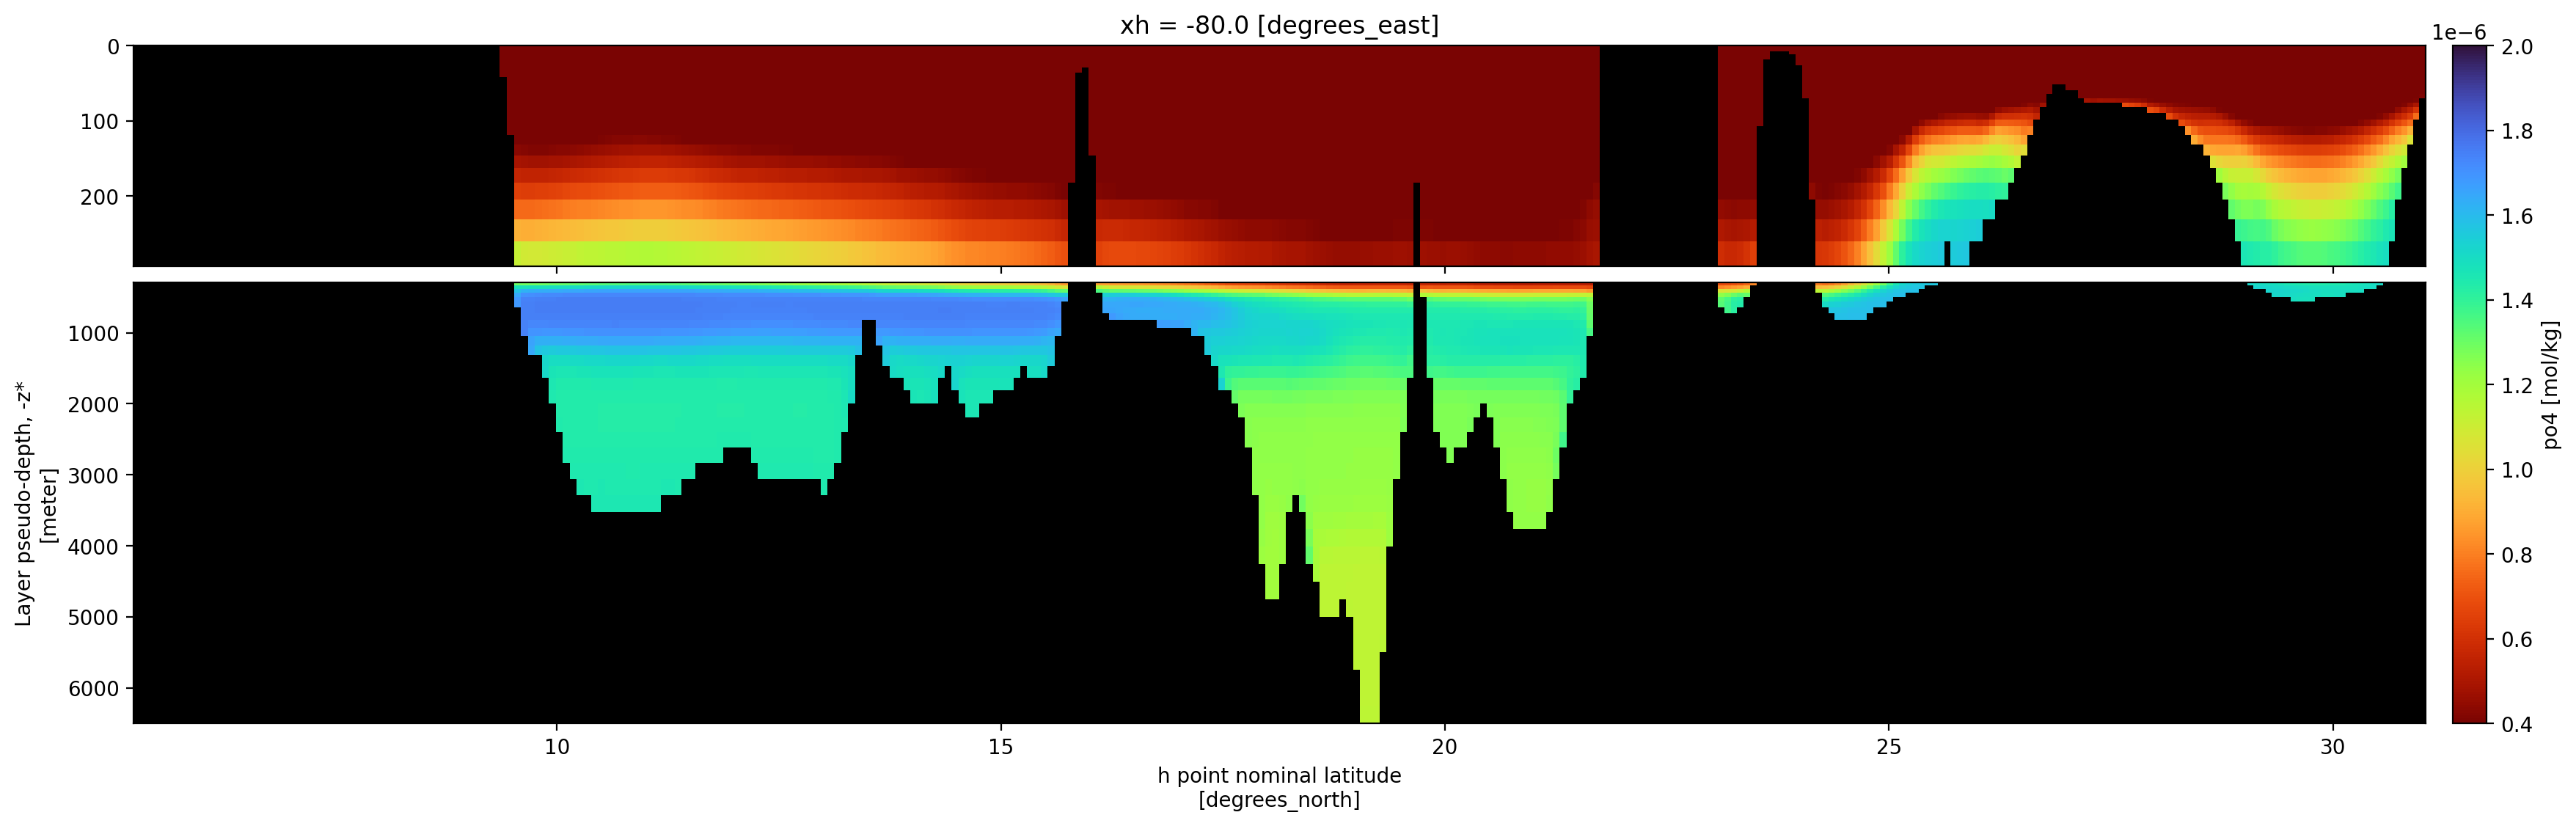

In [14]:
# lon = np.abs(ds.xh- -80).argmin()
# lat = np.abs(ds.yh- 11.5).argmin()
# depth = np.abs(ds.zl- 120).argmin()

fig, ax = plt.subplots(2, 1, figsize=(24,6),height_ratios=[1, 2],sharex=True,dpi=200)
top=ds.po4.where(static.wet_depth).isel(xh=lon,zl=slice(0,40)).mean('time').plot(x='yh',y='zl',vmin=0.4e-6,vmax=2e-6,yincrease=False,cmap=nanmasked,add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
# static.wet_depth.where(static.wet_depth==0).isel(xh=300,yh=slice(135,None),z_l=slice(0,34)).plot(x='yh',y='z_l',yincrease=False,cmap='binary',add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
im=ds.po4.where(static.wet_depth).isel(xh=lon,zl=slice(40,None)).mean('time').plot(x='yh',y='zl',vmin=0.4e-6,vmax=2e-6,yincrease=False,cmap=nanmasked,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
# static.wet_depth.where(static.wet_depth==0).isel(xh=300,yh=slice(135,None),z_l=slice(34,50)).plot(x='yh',y='z_l',yincrease=False,cmap='binary',add_colorbar=False,ax=ax[1]) 
ax[1].set_title('')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
fig.subplots_adjust(hspace=0.05)
fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01,label='po4 [mol/kg]')
# # ax.fill_between(ds.yh,static.depth_ocean.fillna(0.).isel(xh=50),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# ax[0].set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh[520].values) + '$^{\circ}$E')
plt.show()

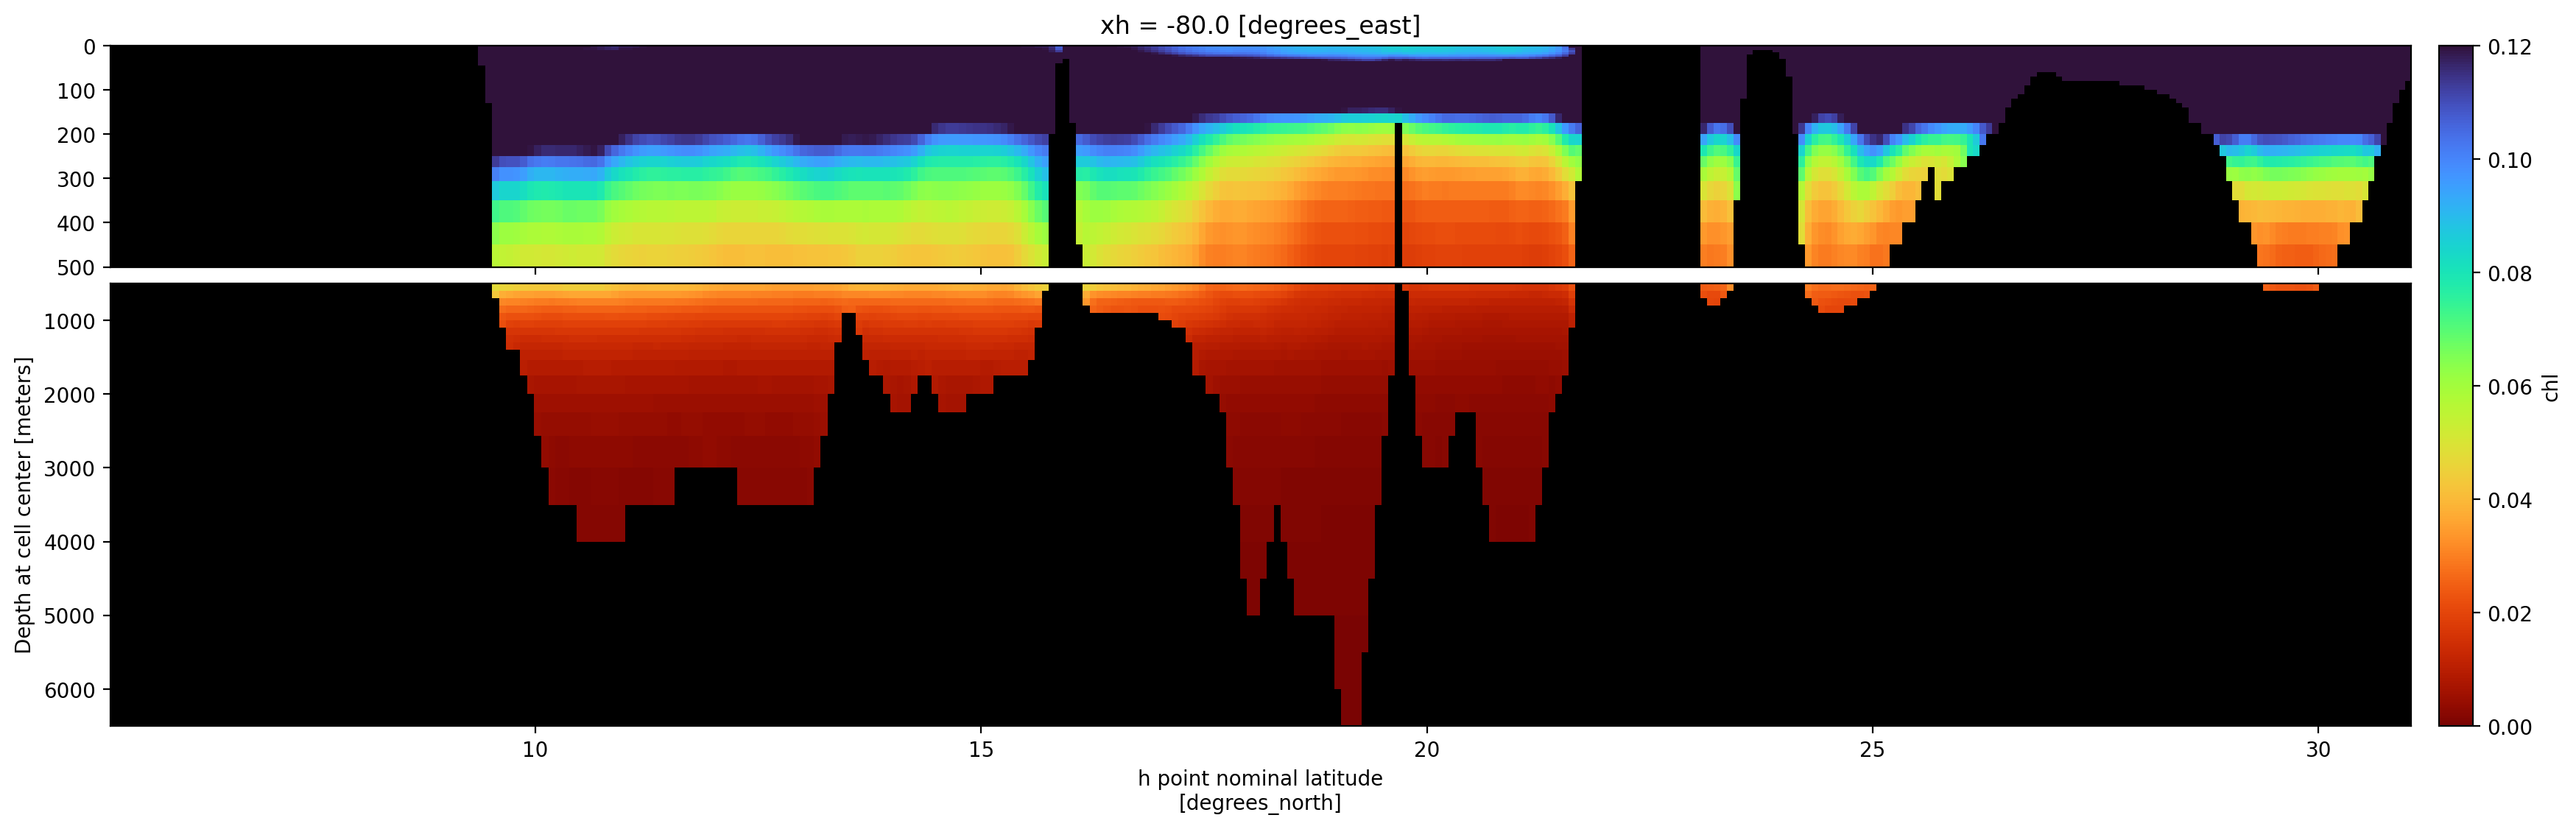

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(24,6),height_ratios=[1, 2],sharex=True,dpi=200)
# lon = np.abs(ds.xh- -80).argmin()
top=ds.chl.isel(xh=lon,z_l=slice(0,30)).mean('time').plot(x='yh',y='z_l',yincrease=False,cmap=nanmasked,vmin=0,vmax=0.12,add_colorbar=False,ax=ax[0]) # deriv lands back on xh 
im=ds.chl.isel(xh=lon,z_l=slice(30,None)).mean('time').plot(x='yh',y='z_l',yincrease=False,cmap=nanmasked,vmin=0,vmax=0.12,add_colorbar=False,ax=ax[1]) # deriv lands back on xh 
ax[1].set_title('')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
fig.subplots_adjust(hspace=0.05)
fig.colorbar(im, ax=ax.ravel().tolist(),pad=0.01,label='chl')
# # ax.fill_between(ds.yh,static.depth_ocean.fillna(0.).isel(xh=50),7000*np.ones(343),color='black') # fake topography since we're in native coordinates
# ax[0].set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh[520].values) + '$^{\circ}$E')
plt.show()

Having established that the budget closes over the box, we can now start to perform analyses on the relative contribution of terms to the budget. Let's begin by plotting the vertically-integrated heat budget terms for the same box as before, only now with vertical extent from surface to 102 meters depth.
### Relative contributions to heat
Start by interpolating the monthly climatology (from monthly 3D temperature dataset) into a daily dataset for comparison. The code takes a bit to run, but we have saved it under /scratch/gpfs/CDEUTSCH/wchu/corals/clim_daily_interp.nc so that we can just load the dataset instead of re-running the code. The hidden cell contains the full code, while the visible cell allows us to load directly.

In [10]:
# # loading monthly data between 1993 - 2019
data_path = '/scratch/gpfs/CDEUTSCH/wchu/corals/nwa12_monthly_thetao.nc'
clim = xr.open_dataset(data_path,chunks='auto')
clim = clim.isel(xh=slice(0,601),yh=slice(0,343))

# clim_thetao = grid.average(clim.thetao,['X','Y']).groupby('time.month').mean('time') # 1D
clim_thetao = clim.thetao.groupby('time.month').mean('time') #3D

#  create monthly time coordinates at the start of each month
monthly_time = pd.date_range("1993-01-01", periods=12, freq="MS")  # Jan 1, Feb 1, ..., Dec 1
clim_thetao = clim_thetao.rename({'month': 'time'})
clim_thetao = clim_thetao.assign_coords(time=monthly_time)

# # add Jan 1 of the *next* year for interpolation to Dec 31
first_point_values = clim_thetao.isel(time=0).values
extra_point = xr.DataArray(
    data=first_point_values[np.newaxis, ...],
    dims=['time'] + list(clim_thetao.dims[1:]),
    coords={k: clim_thetao.coords[k] for k in clim_thetao.coords if k != 'time'},
)
extra_point = extra_point.assign_coords(time=[pd.Timestamp("1994-01-01")])

# concatenate and interpolate
clim_thetao_extended = xr.concat([clim_thetao, extra_point], dim='time')
clim_daily = clim_thetao_extended.resample(time='1D').interpolate('linear')

# trim to exactly one year
clim_daily = clim_daily.sel(time=slice("1993-01-01", "1993-12-31"))

# have to shift by 12 hours to match the time of the theta coordinates
from datetime import timedelta
clim_daily = clim_daily.assign_coords(time=clim_daily.time.get_index('time') + timedelta(hours=12))

# save as netcdf file
clim_daily.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/corals/clim_thetao_daily_interp_3d.nc')

/tmp/ipykernel_1551645/1565223329.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  clim = xr.open_dataset(data_path,chunks='auto')


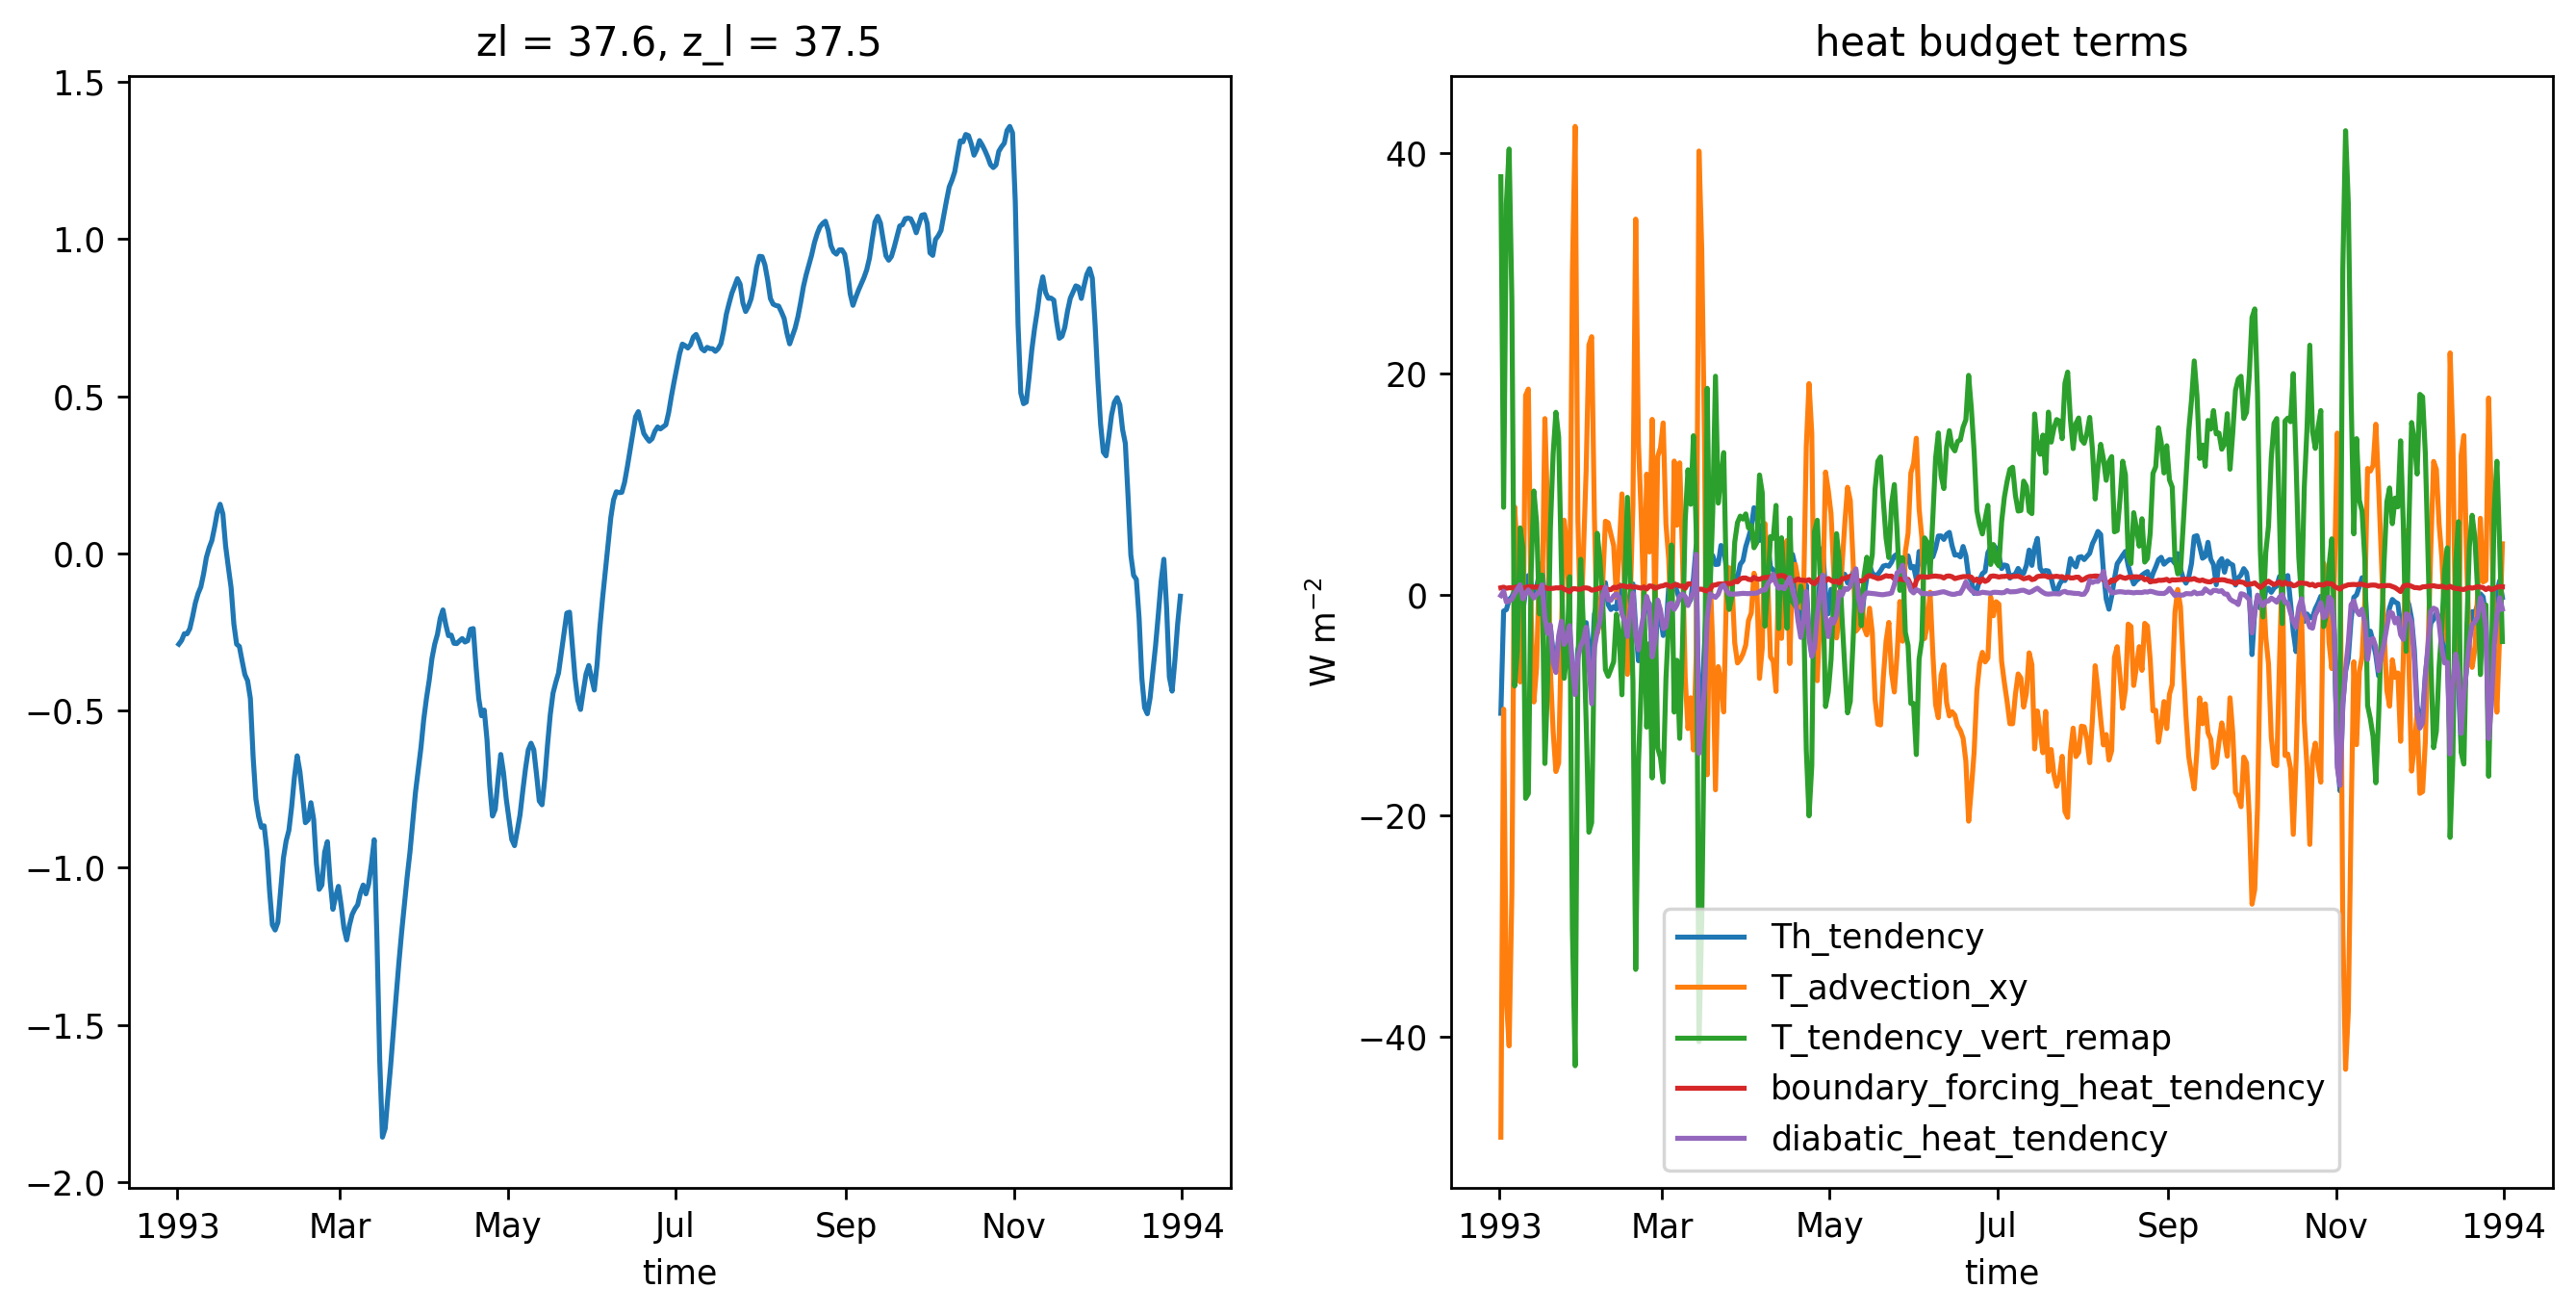

In [15]:
## heat budget terms and temperature time series

test = box.temp.sel(zl=clim_daily.z_l[7],method='nearest') - clim_thetao.thetao.isel(z_l=7) # can also match z_l=15
# discrepancy probably from area-averaged value need to try again with whole domain

fig, ax = plt.subplots(1, 2, figsize=(13,6), dpi=250)
grid.average(test,['X','Y']).plot(x='time',ax=ax[0])

for term in terms['heat']:
    throwaway = grid.average(box[term],['X','Y']).sel(zl=clim_thetao.z_l[7],method='nearest').plot(x='time',ax=ax[1])
# # diff.plot(x='time',ax=ax[1])
ax[1].set_ylabel('W m$^{-2}$')
ax[1].set_title('heat budget terms')
ax[1].legend(terms['heat'],fontsize=10)
plt.show()

In [6]:
box = ds.sel(**{'xh': slice(-80, -75),'yh': slice(22, 27),'zl':slice(0,500)})
box_static = static.sel(**{'xh': slice(-80, -75),'yh': slice(22, 27)})
# box_anom = box.temp.sel(zl=clim_thetao.z_l[7],method='nearest') - clim_thetao.thetao.isel(z_l=7) # can also match z_l=15 (define relative to climatology)

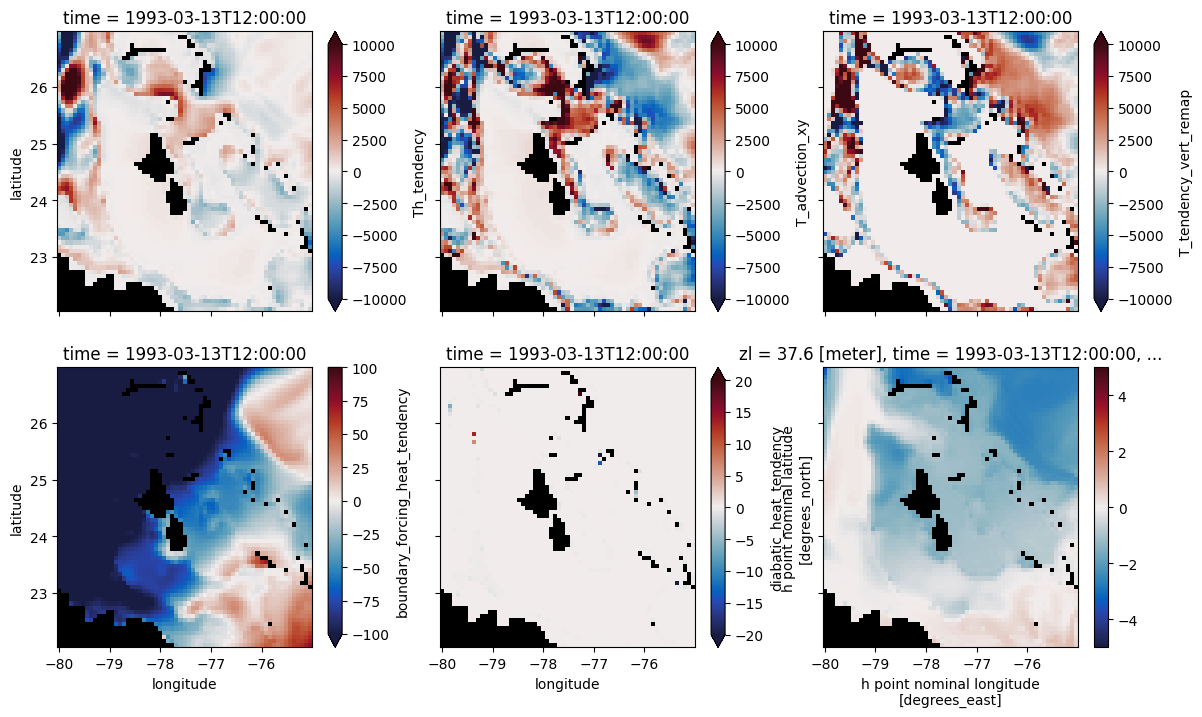

In [24]:
terms = {}
terms['heat'] = ['Th_tendency','T_advection_xy','T_tendency_vert_remap','boundary_forcing_heat_tendency','diabatic_heat_tendency']

vmins = [-10000, -10000, -10000, -100, -20]
vmaxs = [10000,10000,10000,100,20]

# try times 71, 75, and 95 to see wave
fig, ax = plt.subplots(2, 3, figsize=(14,8),sharex=True,sharey=True)
for term in range(len(terms['heat'])):
    box[terms['heat'][term]].sum('zl').isel(time=71).where(box_static.wet>0).plot(x='xh',y='yh',cmap=nanmasked2,vmin=vmins[term],vmax=vmaxs[term],ax=ax.flatten()[term])
    # ax.flatten()[term].set_aspect('equal')
    if term<3:
        ax.flatten()[term].set_xlabel('')
    if term>2:
        ax.flatten()[term].set_xlabel('longitude')
    if term==0 or term==3:
        ax.flatten()[term].set_ylabel('latitude')
    else:
        ax.flatten()[term].set_ylabel('')
# ax.flatten()[-1].axis('off')
box_anom.isel(time=71).where(box_static.wet>0).plot(x='xh',y='yh',cmap=nanmasked2,vmin=-5, vmax=5,ax=ax.flatten()[-1])
plt.show()

### Relative contributions to oxygen

Repeat the same as we did above for heat, only this time to establish an oxygen climatology. Start by identifying the minimum oxygen of the year as an example. Since we are using the oxygen budget, go based off of the volume-integrated oxygen content rather than the average oxygen. Define a box of interest below.

In [5]:
box = ds.sel(**{'xh': slice(-54, -51),'yh': slice(10, 13)})#
depth_min = np.abs(ds.zl- box.depth_ocean.min()).argmin().values
depth_max = np.abs(ds.zl- box.depth_ocean.max()).argmin().values
if (box.depth_ocean.max() <= ds.zl[depth_max]):
	box = box.isel(zl=slice(depth_min,depth_max+1))
else:
	box = box.isel(zl=slice(depth_min,depth_max+2))
# box = ds.isel(zl=slice(0,20))
# box = box.sel(**{'zl':slice(box.depth_ocean.max()-500,box.depth_ocean.max())})#,'zl':slice(0,500)
# box_static = static.sel(**{'xh': slice(-89, -82),'yh': slice(25, 30)})
# h = box.volcello/box.areacello
# box = box.where(box_static.wet_depth)
# box_anom = box.temp.sel(zl=clim_thetao.z_l[7],method='nearest') - clim_thetao.thetao.isel(z_l=7) # can also match z_l=15 (define relative to climatology)

In [14]:
# box.depth_ocean.max().values
# depth_max
# box.zl
# ds.zl[69]

Within this box, we are going to integrate o2 concentration [mol/kg] to get to units of o2 content [mol/kg m$^3$/s]. For the horizontal coordinates, we can simply use the pre-defined xgcm grid, but for the depth coordinate zl, we have to first multiply oxygen by the layer thickness (h) before summing over zl. 

Text(0, 0.5, 'volume-integrated o2 [mol kg$^{-1}$ m$^3$ s$^{-1}$]')

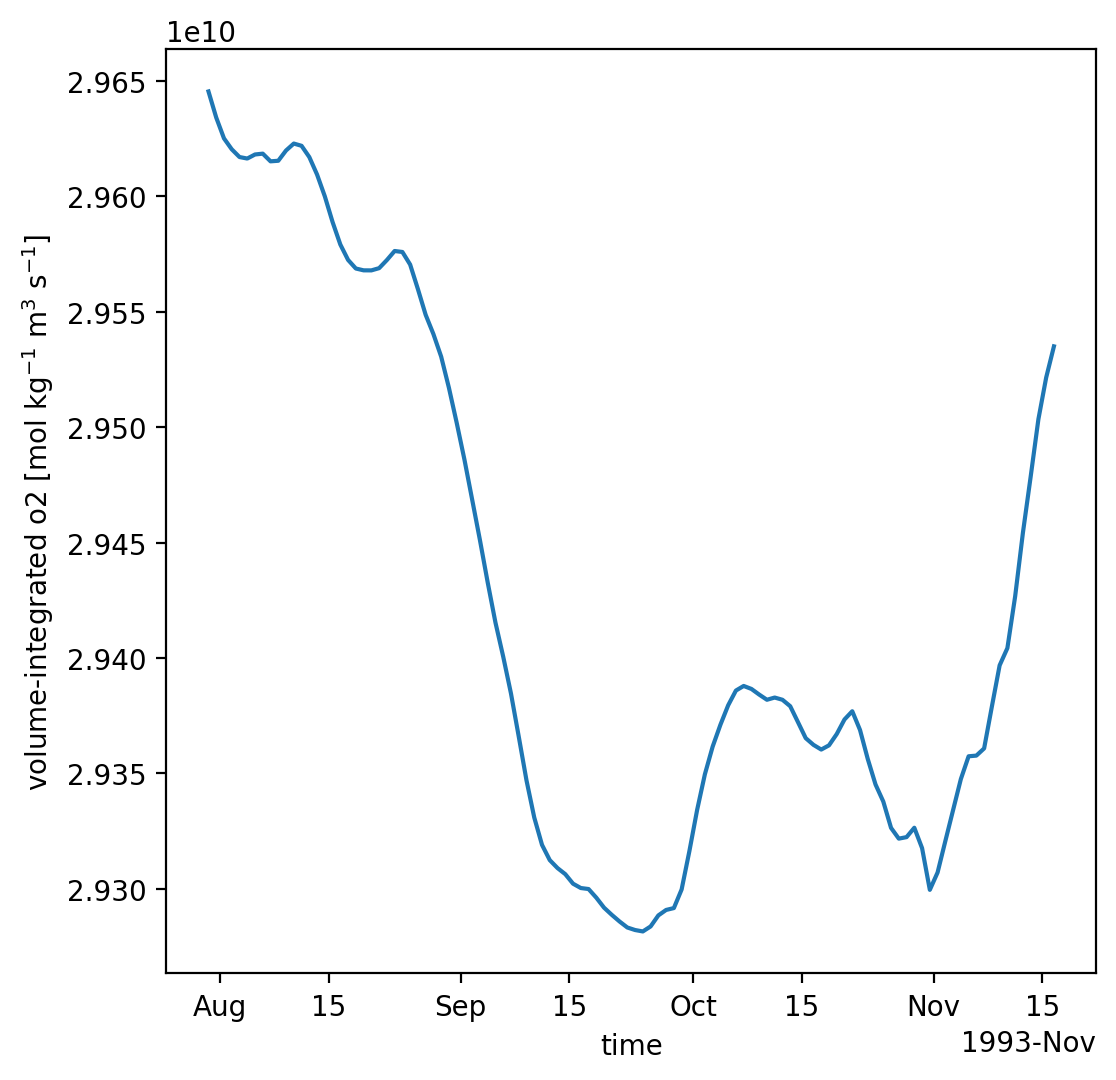

In [11]:
# o2_int = (grid.integrate(ds.o2*h,['X','Y'])).sum('zl')
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
o2_int.isel(time=slice(210,320)).plot(x='time')
ax.set_ylabel('volume-integrated o2 [mol kg$^{-1}$ m$^3$ s$^{-1}$]')

In [39]:
# box.o2.isel(zl=1,time=slice(178,248),xh=20,yh=20).plot(x='time')
# test.plot(x='time')

# o2_diff = box.o2.differentiate('time',datetime_unit='s')

# h = box.volcello/box_static.areacello
# grid.integrate((box.o2*h),['X','Y']).sum('zl').isel(time=slice(2,None)).plot(x='time')


# box.time[60]
# o2_int = grid.integrate((box.o2*h),['X','Y']).sum('zl')+grid.integrate(box.o2h_tendency,['X','Y']).sum('zl')*60*24*24
# o2_int = box.o2.isel(zl=1,time=slice(178,248),xh=20,yh=20)*(h.isel(zl=1,time=slice(178,248),xh=20,yh=20)) + box.o2h_tendency.isel(zl=1,time=slice(178,248),xh=20,yh=20)*60*24*24
# o2_int.isel(time=slice(178,248)).plot(x='time')
# ((grid.average(ds.o2min.isel(time=slice(178,248)),['X','Y'])*static['dzt']).sum('zl')/(static['dzt'].sum('zl'))).plot(x='time')

# (box.o2.isel(zl=1,time=slice(178,248),xh=20,yh=20)*h.isel(zl=1,time=slice(178,248),xh=20,yh=20)).plot(x='time') # mol/kg m

# plt.plot(o2_int)#.plot(x='time')
# (h.isel(zl=1,time=slice(178,248),xh=20,yh=20)*box.o2.isel(zl=1,time=slice(178,248),xh=20,yh=20)).chunk({'time': 70}).differentiate('time',datetime_unit='s').plot(x='time')
# box.o2h_tendency.isel(zl=1,time=slice(178,248),xh=20,yh=20).plot(x='time')

# diff.where(static.wet).sel(**{'xh': slice(-87, -84),'yh': slice(26, 29)})#.isel(time=3).plot(x='xh',y='yh',cmap=nanmasked2,vmin=-1e-12,vmax=1e-12,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})

In [8]:
# box.o2min.isel(time=20).sel(zl=box_static.depth_ocean.fillna(0),method='nearest').plot(x='xh',y='yh',cmap=nanmasked)
# box_static.depth_ocean.plot(x='xh',y='yh')

NameError: name 'box_static' is not defined

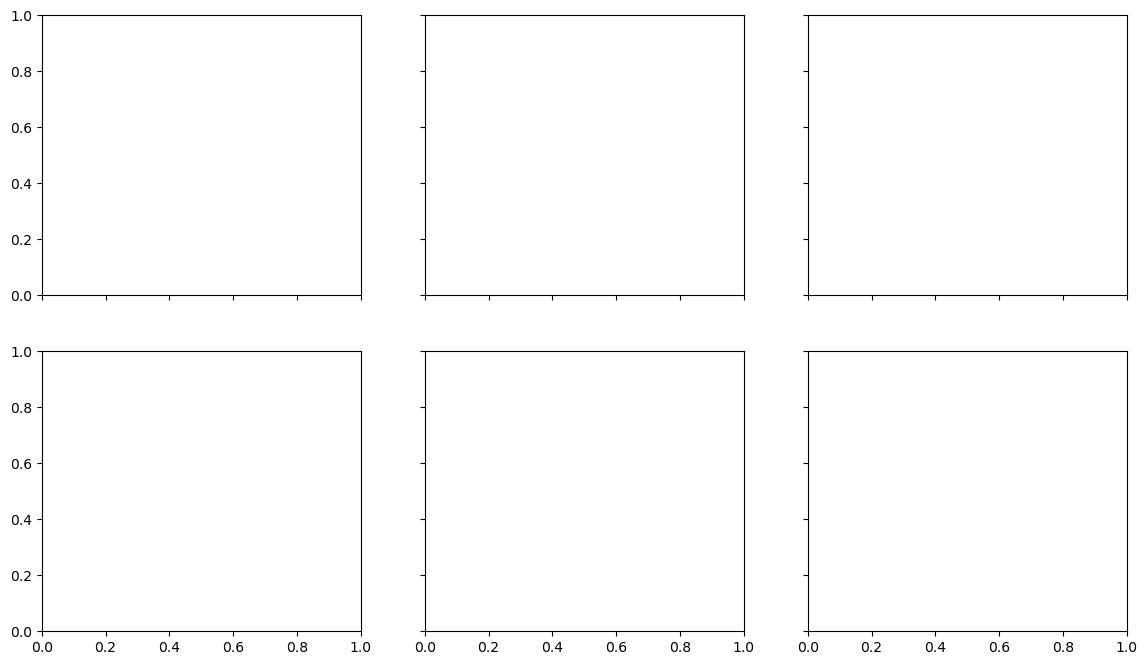

In [9]:
terms = {}
terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

# vmins = [-1e-7,-1e-7,-1e-7,-1e-10,-1e-9,-1e-9]
# vmaxs = [1e-7,1e-7,1e-7,1e-10,1e-9,1e-9]
# ,vmin=vmins[term],vmax=vmaxs[term]

# try times 71, 75, and 95 to see wave
fig, ax = plt.subplots(2, 3, figsize=(14,8),sharex=True,sharey=True)
for term in range(len(terms['o2cont'])):
    if terms['o2cont'][term]=='jo2':
        throwaway = box[terms['o2cont'][term]]/1035
        throwaway.sum('zl').isel(time=20).where(box_static.wet).plot(x='xh',y='yh',cmap=nanmasked2,ax=ax.flatten()[term])
    else:
        box[terms['o2cont'][term]].sum('zl').isel(time=20).where(box_static.wet).plot(x='xh',y='yh',cmap=nanmasked2,ax=ax.flatten()[term])
    # ax.flatten()[term].set_aspect('equal')
    if term<3:
        ax.flatten()[term].set_xlabel('')
    if term>2:
        ax.flatten()[term].set_xlabel('longitude')
    if term==0 or term==3:
        ax.flatten()[term].set_ylabel('latitude')
    else:
        ax.flatten()[term].set_ylabel('')
# ax.flatten()[-1].axis('off')
# box_anom.isel(time=71).where(box_static.wet>0).plot(x='xh',y='yh',cmap=nanmasked2,vmin=-5, vmax=5,ax=ax.flatten()[-1])
plt.show()

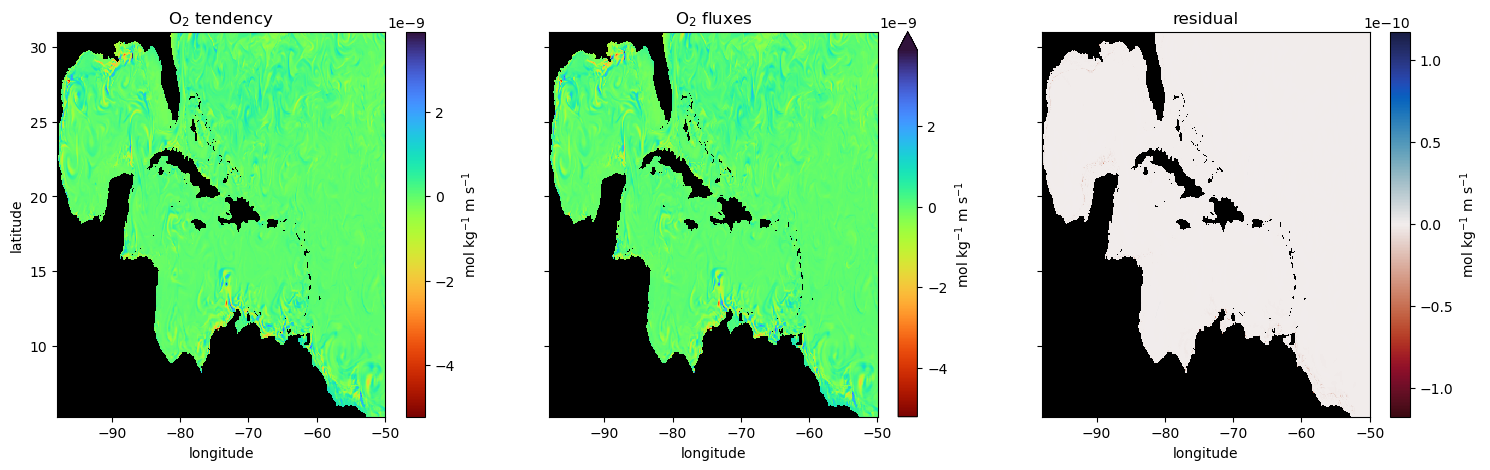

In [24]:
fluxes = box.o2_advection_xy + box.o2h_tendency_vert_remap + box.o2_diffusion_xy + box.o2_vdiffuse_impl + box.jo2/1035 
diff = box.o2h_tendency.sum('zl').squeeze() - fluxes.sum('zl').squeeze()

set_time = 20
o2min = box.o2h_tendency.sum('zl').isel(time=set_time).min().values
o2max = box.o2h_tendency.sum('zl').isel(time=set_time).max().values

fig, ax = plt.subplots(1, 3, figsize=(18,5))
box.o2h_tendency.sum('zl').where(box.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[0],cmap=nanmasked,vmin=o2min,vmax=o2max,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[0].set_title('O$_2$ tendency')
fluxes.sum('zl').where(box.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[1],cmap=nanmasked,vmin=o2min,vmax=o2max,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[1].set_xlabel('longitude')
ax[1].set_title('O$_2$ fluxes')
diff.where(box.wet).isel(time=set_time).plot(x='xh',y='yh',ax=ax[2],cmap=nanmasked2,cbar_kwargs={'label':'mol kg$^{-1}$ m s$^{-1}$'})
ax[2].set_ylabel('')
ax[2].set_yticklabels('')
ax[2].set_xlabel('longitude')
ax[2].set_title('residual')
plt.show()

Now, we can also check that integrating over the entire volume of the box maintains the closure.

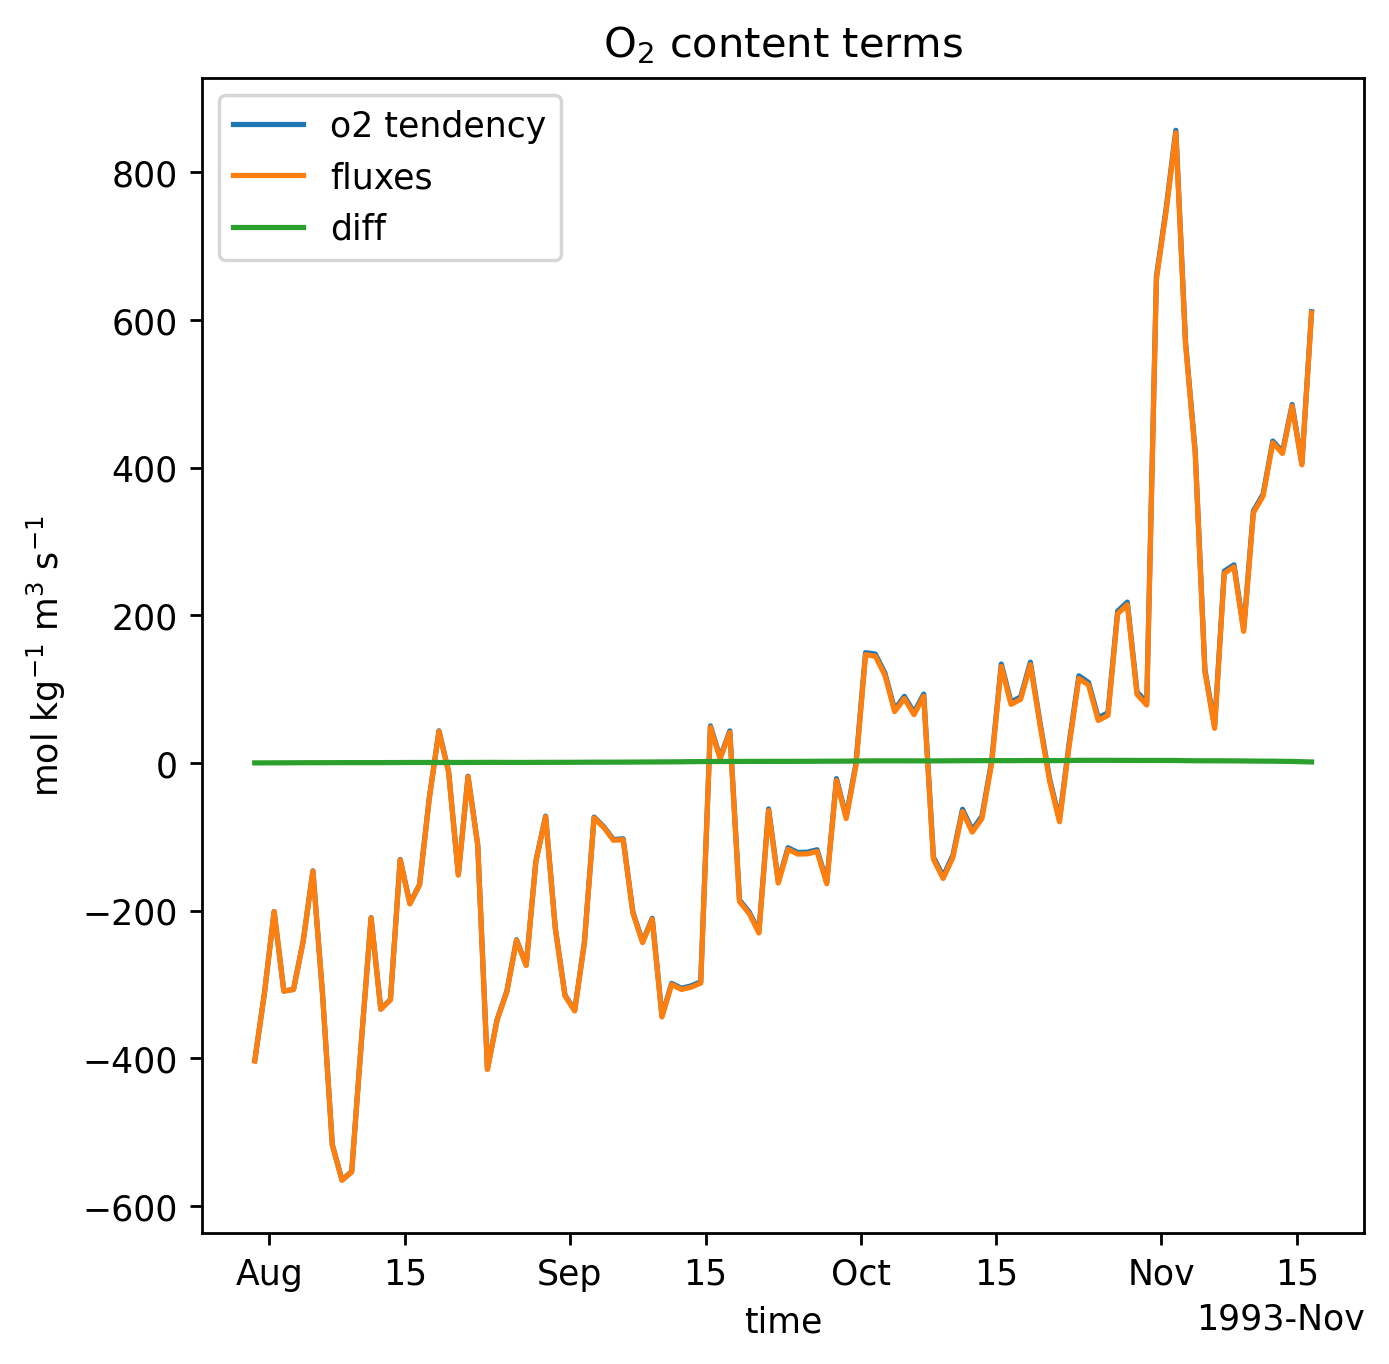

In [25]:
# terms = {}
# terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=250)
throwaway = grid.integrate(box['o2h_tendency'].isel(time=slice(210,320)),['X','Y']).sum(['zl']) # integrate over box volume
throwaway.plot(x='time',ax=ax)
# throwaway = grid.integrate(box['jo2'].isel(time=slice(210,320))/1035,['X','Y']).sum(['zl']) # integrate over box volume
throwaway = grid.integrate(fluxes.isel(time=slice(210,320)),['X','Y']).sum(['zl'])
throwaway.plot(x='time',ax=ax)
# throwaway = grid.integrate(box['o2_advection_xy'].isel(time=slice(210,320))+box['o2h_tendency_vert_remap'].isel(time=slice(210,320)),['X','Y']).sum(['zl'])
# throwaway.plot(x='time',ax=ax)
throwaway = grid.integrate(diff.isel(time=slice(210,320)),['X','Y'])
throwaway.plot(x='time',ax=ax)
ax.set_ylabel('mol kg$^{-1}$ m$^3$ s$^{-1}$')
ax.set_title('O$_2$ content terms')
# ax.legend(['o2 tendency','jo2','net advection'],fontsize=10)
ax.legend(['o2 tendency','fluxes','diff'],fontsize=10)

In [57]:
ds.time[30]

<xarray.DataArray 'time' ()>
array('1993-01-31T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1993-01-31T12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  GREGORIAN
    bounds:         time_bnds

skipped diffusion xy


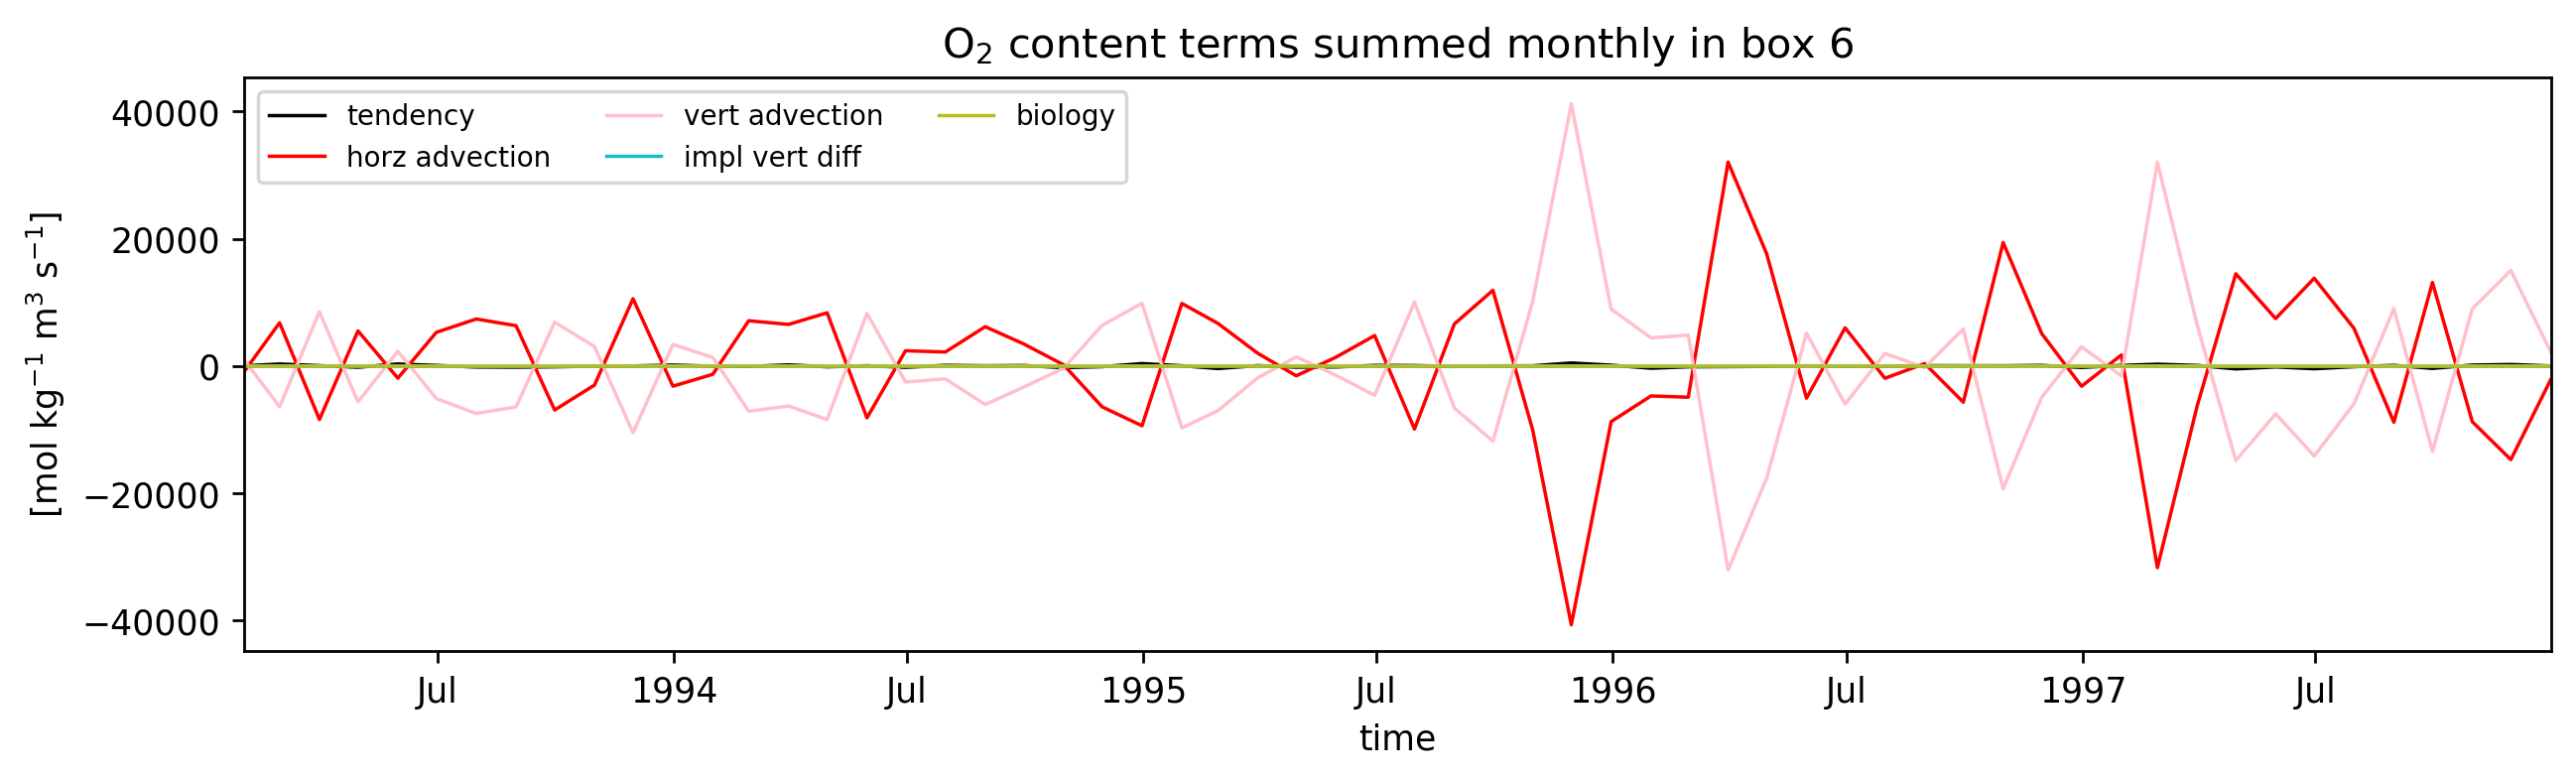

In [14]:
# terms = {}
# terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

colors = ['black','red','pink','grey','tab:cyan','tab:olive']
fig, ax = plt.subplots(1, 1, figsize=(12,3), dpi=250)
for i in range(len(terms['o2cont'])):
    if i == 3:
        print('skipped diffusion xy')
    else:
        # .resample(time='1ME').sum()
        ds[terms['o2cont'][i]].isel(time=slice(1,None)).resample(time='1ME').sum().plot(x='time',ax=ax,linewidth=1,color=colors[i])
ax.set_ylabel('[mol kg$^{-1}$ m$^3$ s$^{-1}$]')
ax.set_xlim([ds.time[30],ds.time[1825]])
ax.set_title('O$_2$ content terms summed monthly in box 6')#+' ('+str(np.round(box.xh.min().values,2))+' to '+str(np.round(box.xh.max().values,2))+'$^o$E, '+str(np.round(box.yh.min().values,2))+' to '+str(np.round(box.yh.max().values))+'$^o$N, '+str(np.round(box.zl.min().values))+' to '+str(np.round(box.zl.max().values))+' m)')
ax.legend(['tendency','horz advection','vert advection','impl vert diff','biology'],fontsize=8,ncols=3)

skipped diffusion xy


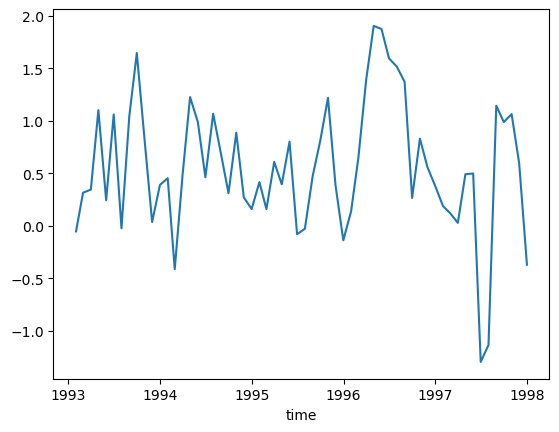

In [47]:
tend = ds[terms['o2cont'][0]].isel(time=slice(1,None)).resample(time='1ME').sum('time')
fluxes = xr.zeros_like(tend)
for i in range(1,len(terms['o2cont'])):
    if i == 3:
        print('skipped diffusion xy')
    else:
        fluxes = fluxes + ds[terms['o2cont'][i]].isel(time=slice(1,None)).resample(time='1ME').sum('time')
# tend = ds[terms['o2cont'][0]].isel(time=slice(0,30))#.resample(time='1ME')
(fluxes - tend).plot(x='time')

skipped diffusion xy


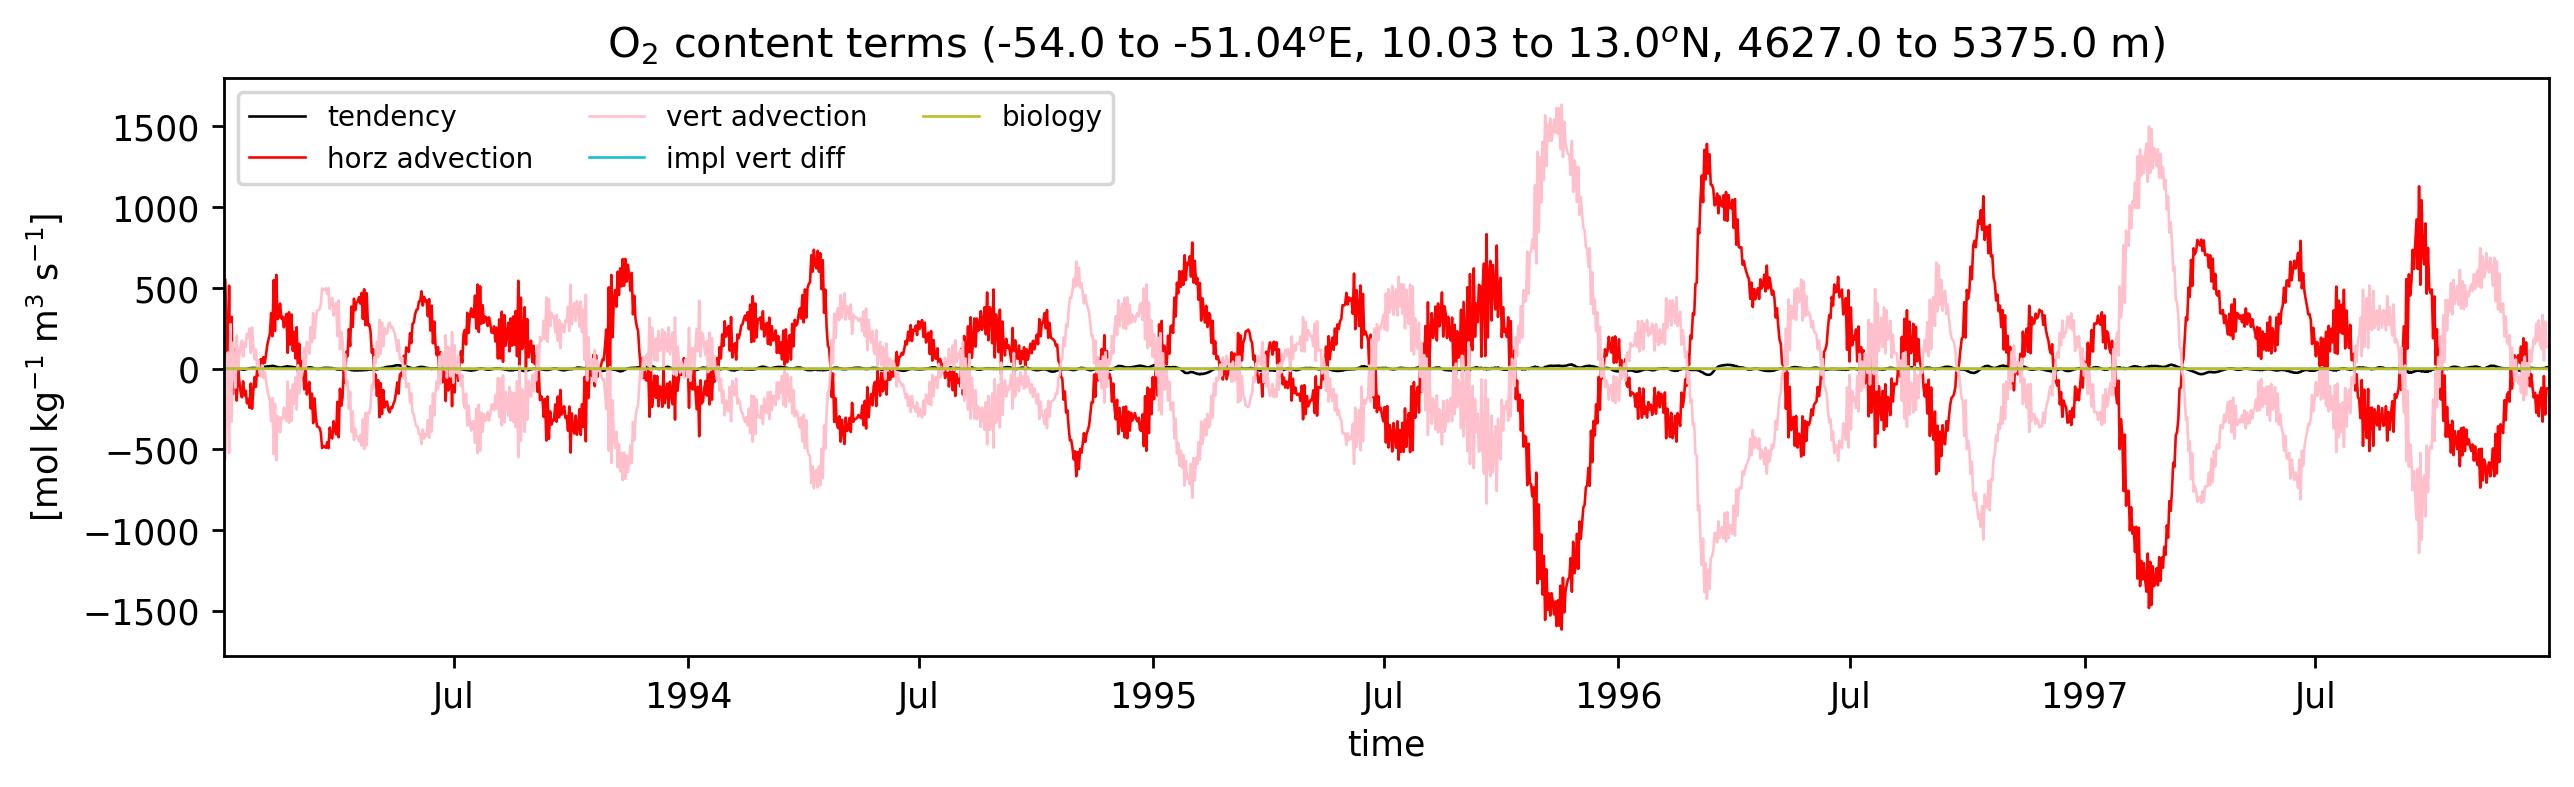

In [15]:
terms = {}
terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

# int_terms = []
# for term in terms['o2cont']:
#     if term=='jo2':
#         throwaway = grid.integrate(box[term]/1035,['X','Y']).sum(['zl']) # integrate over box volume
#         int_terms.append(throwaway.compute())
#         # throwaway.plot(x='time',ax=ax,linewidth=0.5)
#     else:
#         throwaway = grid.integrate(box[term],['X','Y']).sum(['zl'])
#         int_terms.append(throwaway.compute())
#         # throwaway.plot(x='time',ax=ax,linewidth=0.5)

colors = ['black','red','pink','grey','tab:cyan','tab:olive']
fig, ax = plt.subplots(1, 1, figsize=(12,3), dpi=250)
for i in range(len(int_terms)):
    if i == 3:
        print('skipped diffusion xy')
    else:
        int_terms[i].isel(time=slice(1,None)).plot(x='time',ax=ax,linewidth=0.75,color=colors[i])
ax.set_ylabel('[mol kg$^{-1}$ m$^3$ s$^{-1}$]')
ax.set_xlim([ds.time[0],ds.time[-1]])
ax.set_title('O$_2$ content terms'+' ('+str(np.round(box.xh.min().values,2))+' to '+str(np.round(box.xh.max().values,2))+'$^o$E, '+str(np.round(box.yh.min().values,2))+' to '+str(np.round(box.yh.max().values))+'$^o$N, '+str(np.round(box.zl.min().values))+' to '+str(np.round(box.zl.max().values))+' m)')
ax.legend(['tendency','horz advection','vert advection','impl vert diff','biology'],fontsize=8,ncols=3)

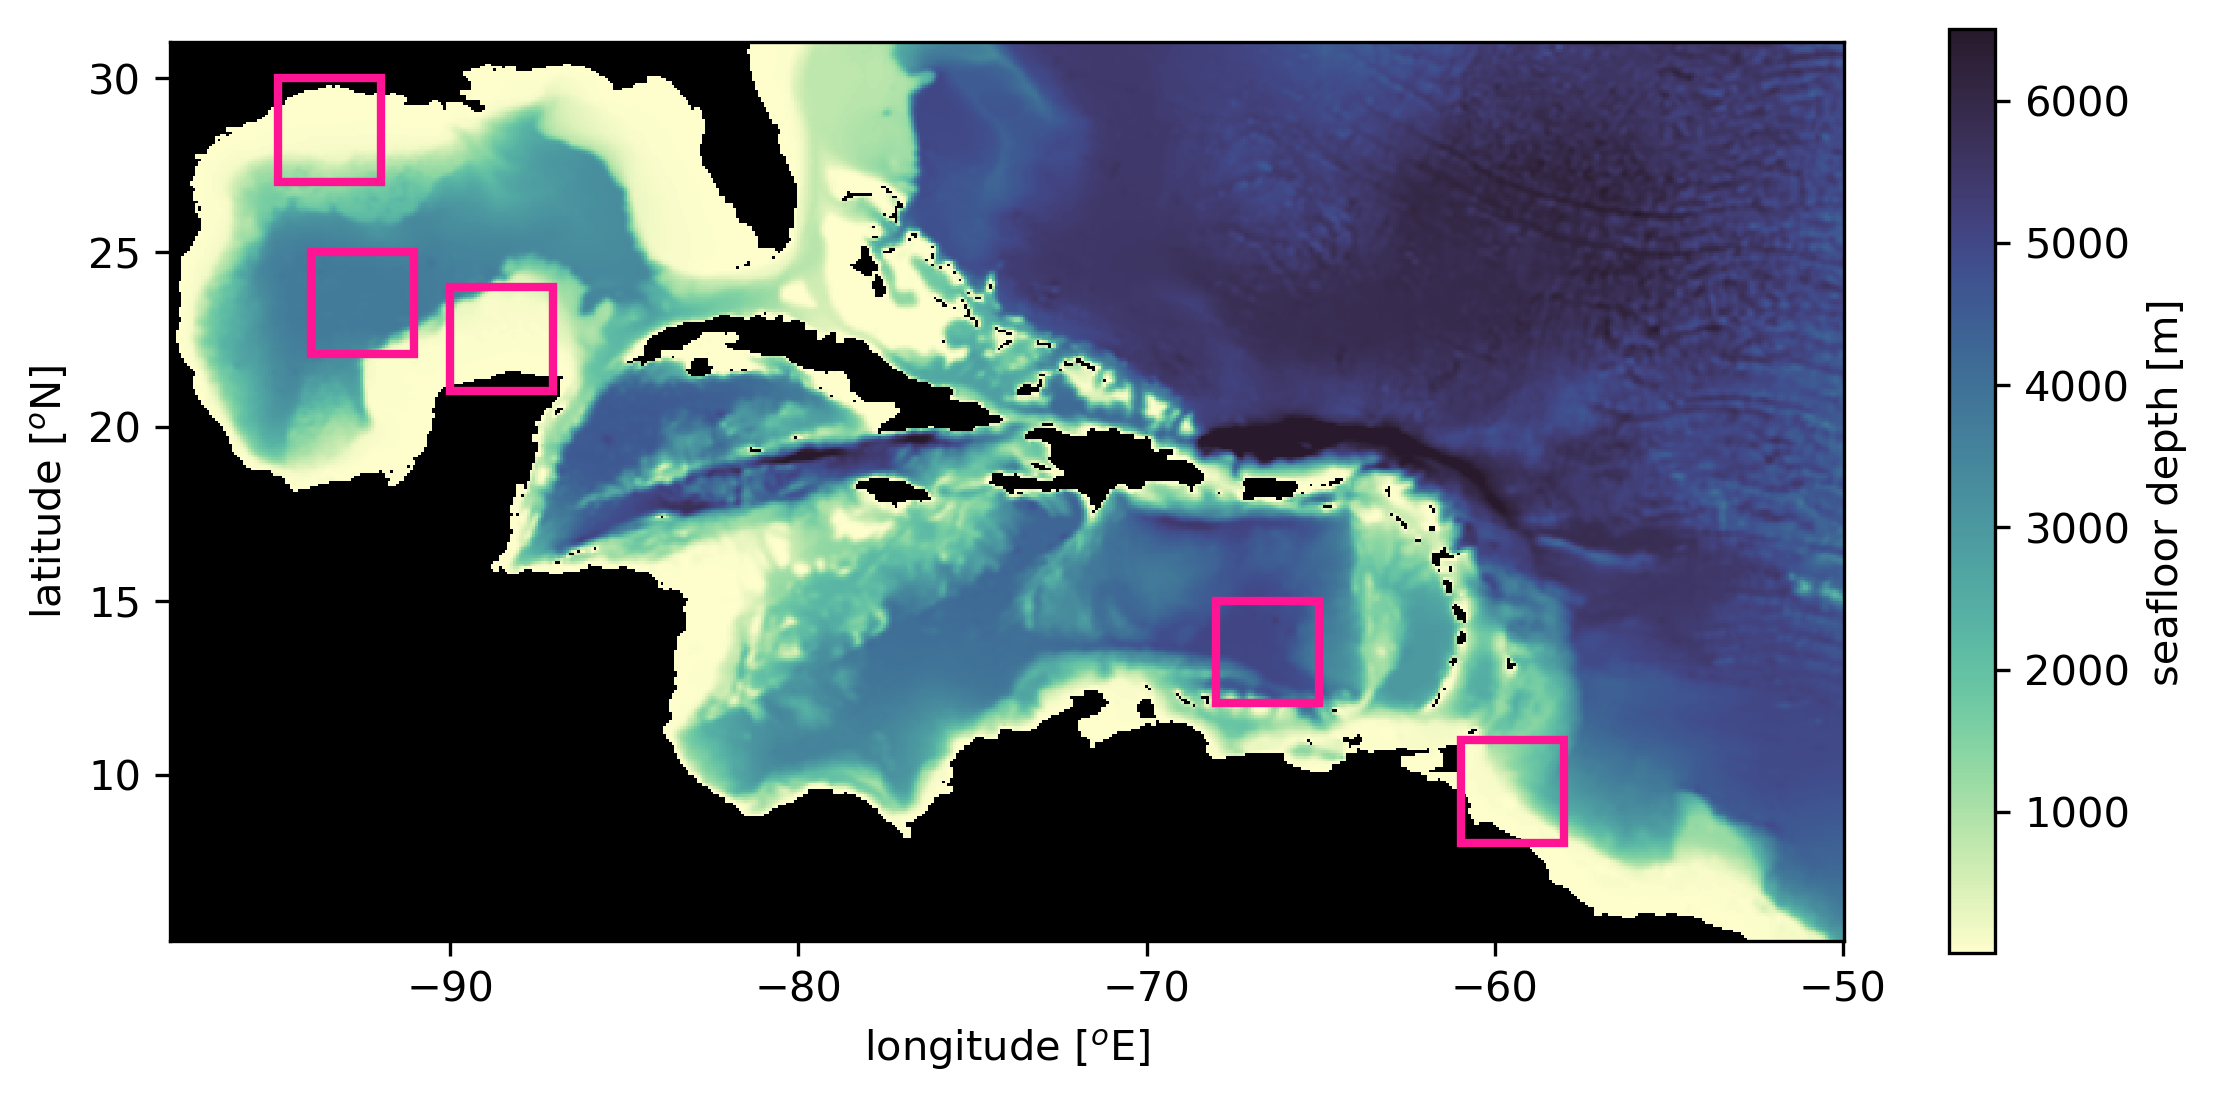

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(9,4), dpi=300)
# nanmasked = plt.get_cmap('cmo.deep').copy()
# nanmasked.set_bad('black')
static.depth_ocean.plot(x='xh',y='yh',cmap=nanmasked,cbar_kwargs={'label':'seafloor depth [m]'})
ax.add_patch(mpl.patches.Rectangle((-94.96, 27.02), 2.96, 2.98, facecolor="none", ec='deeppink', lw=2)) # box 1
ax.add_patch(mpl.patches.Rectangle((-94, 22.07), 2.96 , 2.93, facecolor="none", ec='deeppink', lw=2)) # box 1
ax.add_patch(mpl.patches.Rectangle((-90, 21.03), 2.96, 2.97, facecolor="none", ec='deeppink', lw=2)) # box 1
ax.add_patch(mpl.patches.Rectangle((-68, 12.07), 2.96, 2.93, facecolor="none", ec='deeppink', lw=2)) # box 1
ax.add_patch(mpl.patches.Rectangle((-60.96, 8.05), 2.96, 2.95, facecolor="none", ec='deeppink', lw=2)) # box 1
ax.set_xlabel('longitude [$^o$E]')
ax.set_ylabel('latitude [$^o$N]')
ax.set_aspect('equal')

skipped diffusion xy


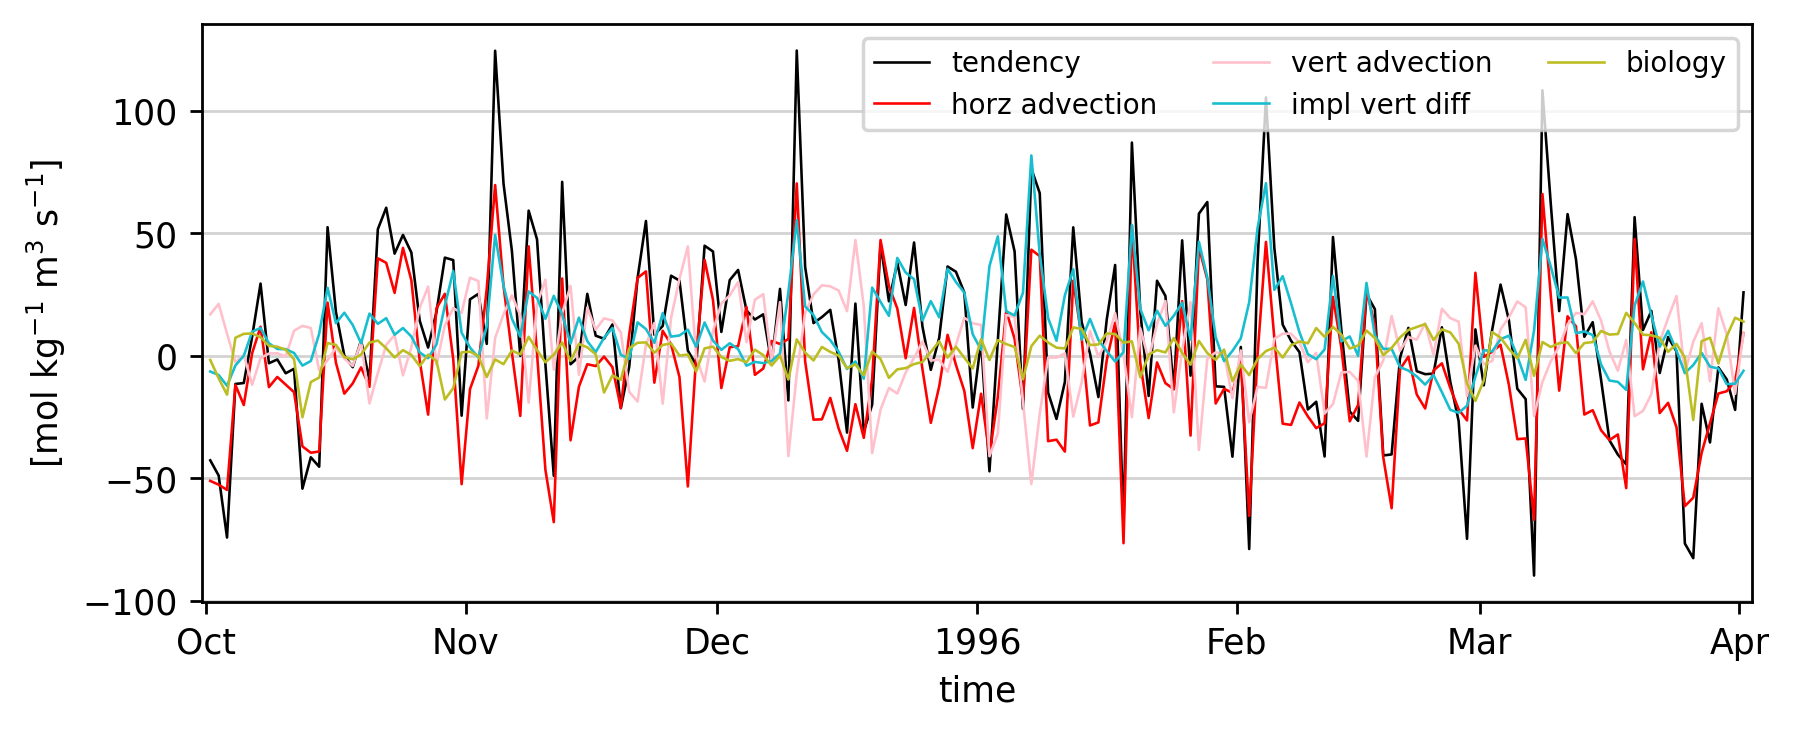

In [38]:
# terms = {}
# terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_diffusion_xy','o2_vdiffuse_impl','jo2']

# colors = ['black','red','pink','grey','tab:cyan','tab:olive']
fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=250)
plt.grid(axis='y',color='lightgray')
for i in range(len(terms['o2cont'])):
    if i == 3:
        print('skipped diffusion xy')
    # elif i == 5:
    #     print('skipped bio xy')
    # elif i == 2:
    #     print('skipped vert adv xy')
    else:
        box[terms['o2cont'][i]].sel(time=slice('1995-10-01','1996-04-01')).plot(x='time',ax=ax,linewidth=0.75,color=colors[i])
ax.set_ylabel('[mol kg$^{-1}$ m$^3$ s$^{-1}$]')
ax.set_xlim([box.time.sel(time='1995-9-30'),box.time.sel(time='1996-04-02')])
# ax.set_title('O$_2$ content terms'+' ('+str(np.round(box.xh.min().values,2))+' to '+str(np.round(box.xh.max().values,2))+'$^o$E, '+str(np.round(box.yh.min().values,2))+' to '+str(np.round(box.yh.max().values))+'$^o$N, '+str(np.round(box.zl.min().values))+' to '+str(np.round(box.zl.max().values))+' m)')
ax.legend(['tendency','horz advection','vert advection','impl vert diff','biology'],fontsize=8,ncols=3)

In [7]:
box_budget = xr.merge([int_terms[i].rename(terms['o2cont'][i]) for i in range(len(int_terms))])
box_budget.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/CEFI-regional-MOM6/exps/NWA12.COBALT/ANALYSIS/budgets/box5.nc')

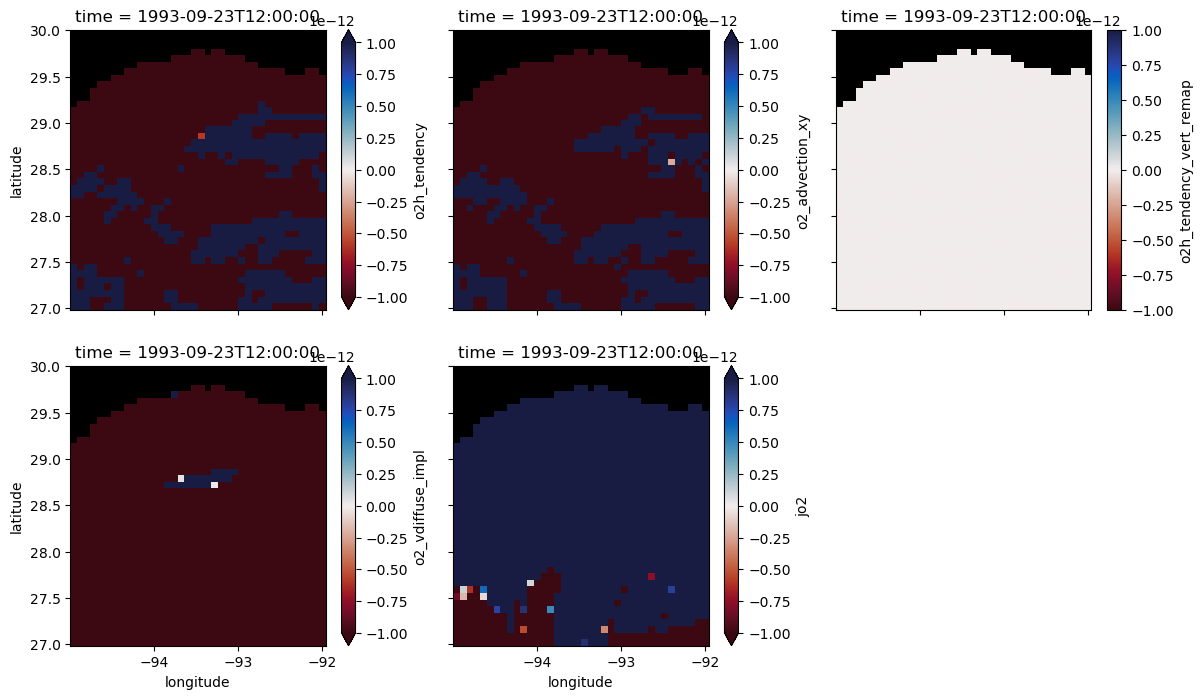

In [19]:
# # h = box.volcello/box_static.areacello

# fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=250)
# throwaway = grid.integrate(box.o2.isel(time=slice(210,320))*h.isel(time=slice(210,320)),['X','Y']).sum(['zl']) # integrate over box volume
# throwaway.plot(x='time')
# plt.ylabel('[mol/kg m$^3$]')

terms = {}
terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_vdiffuse_impl','jo2'] # omit o2_diffusion_xy

vmins = [-1e-12,-1e-12,-1e-12,-1e-12,-1e-12,-1e-12]
vmaxs = [1e-12,1e-12,1e-12,1e-12,1e-12,1e-12]

# try times 71, 75, and 95 to see wave
fig, ax = plt.subplots(2, 3, figsize=(14,8),sharex=True,sharey=True)
for term in range(len(terms['o2cont'])):
    if terms['o2cont'][term]=='jo2':
        throwaway = box[terms['o2cont'][term]].sum('zl').isel(time=265).where(box.wet)/1035
        throwaway.plot(x='xh',y='yh',vmin=vmins[term],vmax=vmaxs[term],cmap=nanmasked2,ax=ax.flatten()[term])
    else:
        box[terms['o2cont'][term]].sum('zl').isel(time=265).where(box.wet).plot(x='xh',y='yh',vmin=vmins[term],vmax=vmaxs[term],cmap=nanmasked2,ax=ax.flatten()[term])
    # ax.flatten()[term].set_aspect('equal')
    if term<3:
        ax.flatten()[term].set_xlabel('')
    if term>2:
        ax.flatten()[term].set_xlabel('longitude')
    if term==0 or term==3:
        ax.flatten()[term].set_ylabel('latitude')
    else:
        ax.flatten()[term].set_ylabel('')
ax.flatten()[-1].axis('off')
# box_anom.isel(time=71).where(box_static.wet>0).plot(x='xh',y='yh',cmap=nanmasked2,vmin=-5, vmax=5,ax=ax.flatten()[-1])
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3928845/1392701215.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('[$\mu$mol/kg m/s]')


Text(0.5, 1.0, 'Date: 1993-07-28')

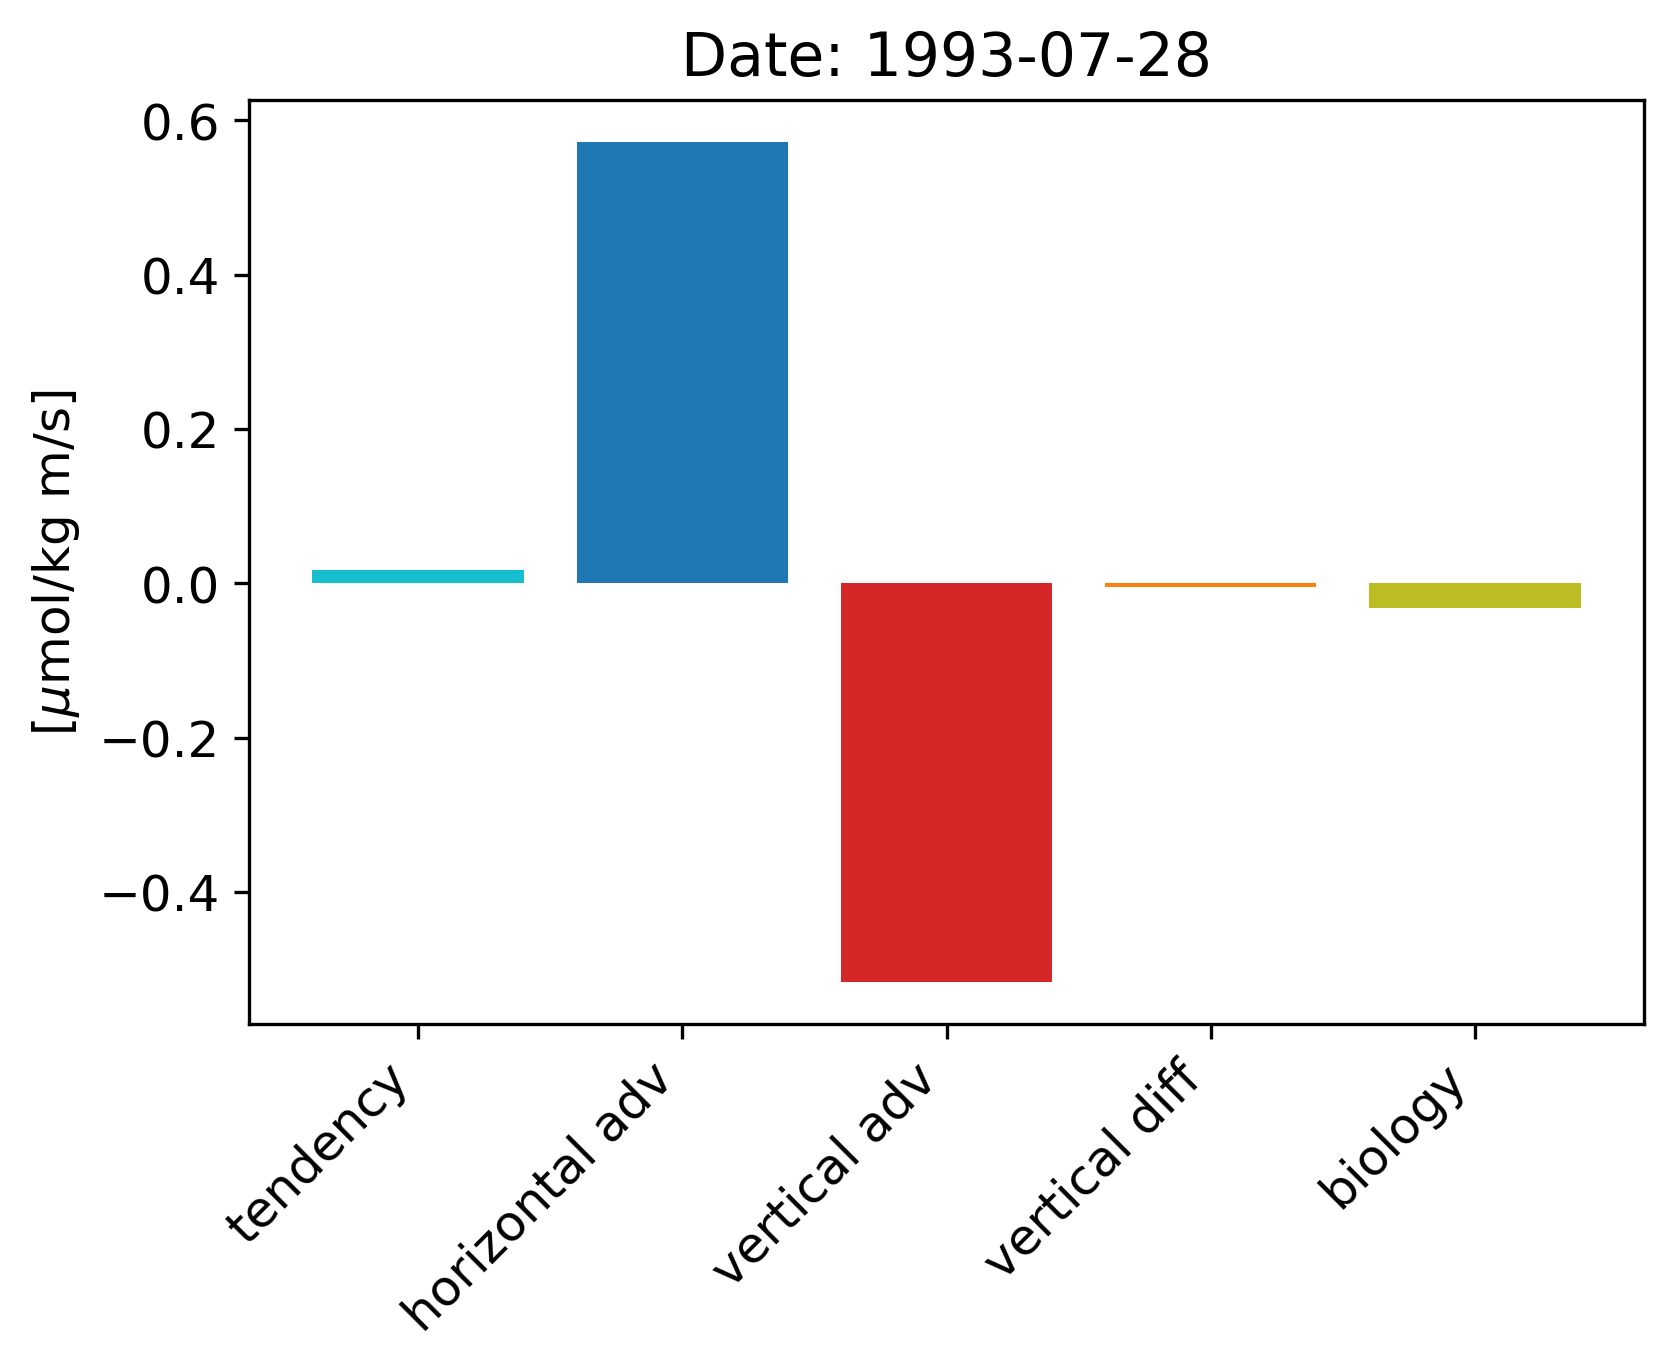

In [41]:
# box_int = box.sum(['xh','yh','zl'])
# terms = {}
# terms['o2cont'] = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap','o2_vdiffuse_impl','jo2']

# counts = [1e6*box_int[terms['o2cont'][i]].isel(time=208) for i in range(len(terms['o2cont']))] 
# counts[-1] = counts[-1]/1035
# plt.rcParams.update({'font.size': 12})

# fig, ax = plt.subplots(dpi=300,figsize=(6,4))

# bar_labels = ['tendency','horizontal adv','vertical adv', 'vertical diff', 'biology']
# bar_colors = ['tab:cyan','tab:blue', 'tab:red', 'tab:orange', 'tab:olive']

# ax.bar(bar_labels, counts, color=bar_colors)

# ax.set_ylabel('[$\mu$mol/kg m/s]')
# plt.xticks(rotation=45,ha='right')
# ax.set_title(label='Date: ' + ds.time[208].dt.strftime('%Y-%m-%d').values)

# plt.show()

In [8]:
# clim_o2 = grid.average(clim.o2,['X','Y']).groupby('time.month').mean('time') # 1D 
clim_o2 = clim.o2.groupby('time.month').mean('time') # 3D

#  create monthly time coordinates at the start of each month
monthly_time = pd.date_range("1993-01-01", periods=12, freq="MS")  # Jan 1, Feb 1, ..., Dec 1
clim_o2 = clim_o2.rename({'month': 'time'})
clim_o2 = clim_o2.assign_coords(time=monthly_time)

# # add Jan 1 of the *next* year for interpolation to Dec 31
first_point_values = clim_o2.isel(time=0).values
extra_point = xr.DataArray(
    data=first_point_values[np.newaxis, ...],
    dims=['time'] + list(clim_o2.dims[1:]),
    coords={k: clim_o2.coords[k] for k in clim_o2.coords if k != 'time'},
)
extra_point = extra_point.assign_coords(time=[pd.Timestamp("1994-01-01")])

# concatenate and interpolate
clim_o2_extended = xr.concat([clim_o2, extra_point], dim='time')
clim_daily = clim_o2_extended.resample(time='1D').interpolate('linear')

# trim to exactly one year
clim_daily = clim_daily.sel(time=slice("1993-01-01", "1993-12-31"))

# have to shift by 12 hours to match the time of the theta coordinates
from datetime import timedelta
clim_daily = clim_daily.assign_coords(time=clim_daily.time.get_index('time') + timedelta(hours=12))

# save as netcdf file
clim_daily.to_netcdf('/scratch/gpfs/CDEUTSCH/wchu/corals/clim_o2_daily_interp_3d.nc')

In [6]:
# # loading monthly data between 1993 - 2019
data_path = '/scratch/gpfs/CDEUTSCH/wchu/corals/clim_o2_daily_interp_3d.nc'
clim_o2 = xr.open_dataset(data_path,chunks='auto')

In [2]:
# test = ds.o2.sel(zl=clim_o2.z_l[7],method='nearest') - clim_o2.o2.isel(z_l=7) # can also match z_l=15

fig, ax = plt.subplots(1, 1, figsize=(6,3), dpi=120)
anom = test.isel(time=0).plot(x='xh',y='yh',vmin=-0.00005, vmax=0.00005, cmap=nanmasked2)
ax.set_aspect('equal')

def animate(frame):
    anom.set_array(test.isel(time=frame))
    ax.set_title(label='Date: ' + ds.time[frame].dt.strftime('%Y-%m-%d').values + '  Depth: '+str(clim_o2.z_l[7].values) + ' m')
    plt.tight_layout()
                   
ani = animation.FuncAnimation(fig, animate, frames=365)
ani.save('/scratch/gpfs/CDEUTSCH/wchu/images/clim_o2_anom_z_l7.gif', writer='imagemagick', fps = 10) #Save animation as gif-file

HTML(ani.to_jshtml())

In [21]:
# fig, ax = plt.subplots(1, 1, figsize=(18,4))
# (ds.o2min.isel(time=0,xh=50)*static.dzt).differentiate('z_l',varargs=static.dzt).isel(yh=slice(165,315),z_l=slice(0,47)).plot(x='yh',y='z_l',yincrease=False,cmap=nanmasked2,ax=ax)
# test = np.gradient(ds.o2min.isel(time=0,xh=50),static.dzt.squeeze(),axis=0)
# test = np.gradient(ds.o2min.isel(time=0,xh=50))
# test#.squeeze()
# plt.pcolormesh(test)
# ds.o2min.isel(time=0,xh=50)
# # ax.fill_between(ds.xh,static.depth_ocean.isel(yh=200),7000*np.ones(601),color='black') # fake topography since we're in native coordinates
# # ax.invert_yaxis()
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(18,4))
# test = grid.interp(ds.o2min.isel(time=0,xh=50),'Y') # shift to xq in prep for deriv
# o2_min = grid.derivative(test,'Y').isel(xh=50,yh=slice(165,315),z_l=slice(0,48)).plot(x='yh',y='z_l',yincrease=False,vmin=-1e-9,vmax=1e-9,cmap=nanmasked2,ax=ax) # deriv lands back on xh 
# # ax.fill_between(ds.xh,static.depth_ocean.isel(yh=200),7000*np.ones(601),color='black') # fake topography since we're in native coordinates
# ax.set_title(label='Date: ' + ds.time[0].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh[50].values) + '$^{\circ}$E')
# plt.show()

# def animate(frame):
#     test = grid.interp(ds.o2min.isel(time=frame,xh=50),'Y')
#     o2_min.set_array(grid.derivative(test,'Y').isel(xh=50,yh=slice(165,315),z_l=slice(0,48)))
#     ax.set_title(label='Date: ' + ds.time[frame].dt.strftime('%Y-%m-%d').values + '  Longitude: {:0.2f}'.format(ds.xh[50].values) + '$^{\circ}$E')
#     plt.tight_layout()
                   
# ani = animation.FuncAnimation(fig, animate, frames=333)
# ani.save('/scratch/gpfs/CDEUTSCH/wchu/images/o2_merderiv_xh50.gif', writer='imagemagick', fps = 10) #Save animation as gif-file

# HTML(ani.to_jshtml())

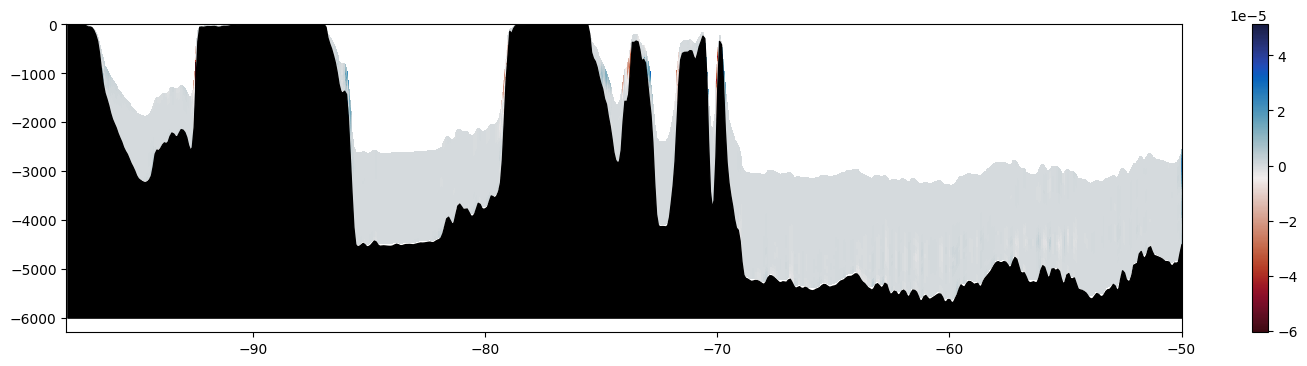

In [31]:
### get zl index of boundary

# max_zl = ds.zl.sel(zl=static.depth_ocean.fillna(0),method='nearest') # fill na with 0 to accoun for surface regions
# test_idx = np.asarray(np.where(max_zl[200,:]==ds.zl))
# max_zl_ind = max_zl[200,:].copy()
# max_zl_ind[test_idx[1]] = test_idx[0]
# max_zl_ind = max_zl_ind.astype('int')
# plt.plot(max_zl_true[0,:])
# plt.plot(ds.zl[max_zl[0].astype('int')])

# fig, ax = plt.subplots(1, 1, figsize=(18,4))
# o2_min = ds.o2min.isel(time=0).isel(yh=200).plot(x='xh',y='zl',vmin=0,yincrease=False,cmap=nanmasked,ax=ax)
# # ax.fill_between(ds.xh,static.depth_ocean.isel(yh=200),7000*np.ones(601),color='black') # fake topography since we're in native coordinates
# plt.plot(ds.xh,ds.zl[max_zl_ind],color='red')
# plt.plot(ds.xh,ds.zl[max_zl_up1],color='orange')

# max_zl_up1 = np.where(max_zl_ind==0,max_zl_ind,max_zl_ind-1) # all the areas not already at the surface are raised by one zl layer

# max_zl_up1
# # ax.invert_yaxis()
# plt.show()

# static.depth_ocean[200,:].plot(x='xh')
# static.depth_ocean[200,:].fillna(0).plot(x='xh')

# test = ds.s_l*static.depth_ocean
# test.isel(s_l=-1).plot(x='xh',y='yh')
# # ds

# ds.h.isel(yh=200,time=0).plot(x='xh',y='s_l')
# o2_min = ds.o2.isel(time=0).isel(yh=200).plot(x='xh',y='s_l',vmin=0,yincrease=False,cmap=nanmasked,ax=ax)
# plt.contour(ds.xh,test.isel(yh=200),ds.o2.isel(time=0,yh=200))
# ax.fill_between(ds.xh,static.depth_ocean.isel(yh=200),7000*np.ones(601),color='black') # fake topography since we're in native coordinates

# z = (ds['e'][0,:-1,200,:] + ds['e'][0,0:,200,:] ) / 2
# z = z.fillna(0)
# x = ds.xh + 0*z
# elim = ds.e.min(),ds.e.max()
# xhlim = ds.xh.min(),ds.xh.max()

# x.transpose().plot()
# ds.o2.isel(time=0).isel(yh=200).plot(x='xh',y='s_l',vmin=0,yincrease=False,cmap=nanmasked)

test = ds.o2[0,-31:,200,:]
test_diff = test.differentiate('s_l')
# test_diff = grid.derivative(test,'X')
# test_diff

# slope = grid.derivative(static.depth_ocean.fillna(0),'X')
# slope.isel(xq=slice(0,-1),yh=200).plot(x='xq')
# sin_slope = np.sin(slope)
# cos_slope.isel(xq=slice(0,-1),yh=200).plot(x='xq')

test_diff_cos = test_diff.values*sin_slope.isel(yh=200).values
# test_diff_cos.shape
# test_diff
fig, ax = plt.subplots(1, 1, figsize=(18,4))
# # o2 = plt.pcolormesh(x.T,z,ds.o2[0,:,200,:],cmap=nanmasked)
# o2 = plt.pcolormesh(x.T,z,test_diff,cmap=nanmasked2,vmin=-0.0015,vmax=0.0015)
o2 = plt.pcolormesh(x.T[-31:,:],z[-31:,:],test_diff_cos,cmap=nanmasked2)
ax.fill_between(ds.xh,-static.depth_ocean.fillna(0).isel(yh=200),-6000*np.ones(601),color='black') # fake topography since we're in native coordinates
# ax.set_facecolor('black')
fig.colorbar(o2,ax=ax)



# plt.xlim(xhlim); plt.ylim(elim);
# plt.plot(ds.xh, ds.e[0,:,200,:].T, 'k');

# ds.o2.isel(time=0,yh=0,s_l=70).plot(x='xh')
# ds.o2.isel(time=0,yh=0,s_l=71).plot(x='xh')
# ds.o2.isel(time=0,yh=0,s_l=72).plot(x='xh')#,y='s_l',cmap=nanmasked)
# plt.plot(ds.xh, ds.e[0,:,200,:].T,'k');

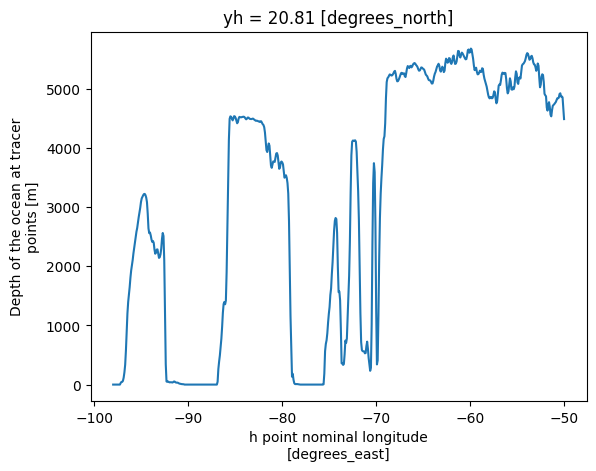

In [19]:
# ds.o2.isel(time=0,yh=200,s_l=slice(-10,-1)).plot(x='xh',y='s_l',cmap=nanmasked)
# test = ds.o2[0,-10:-1,200,:]
# test_diff = test.differentiate('xh')
# fig, ax = plt.subplots(2, 1, figsize=(18,10))
# o2 = ax[0].contourf(x.T[-10:-1,:],z[-10:-1,:],ds.o2[0,-10:-1,200,:],cmap=nanmasked)
# fig.colorbar(o2,ax=ax[0])
# ax[0].set_xlim(xhlim); ax[0].set_ylim(elim);
# o2_diff = ax[1].contourf(x.T[-10:-1,:],z[-10:-1,:],test_diff,cmap=nanmasked2)
# ax[1].set_xlim(xhlim); ax[1].set_ylim(elim);
# fig.colorbar(o2_diff,ax=ax[1])
static.depth_ocean.isel(yh=200).fillna(0).plot(x='xh')